# Uso de la GPU

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) física(s),", len(logical_gpus), "GPU(s) lógica(s)")
        print("Funciona")
    except RuntimeError as e:
        print(e)
else:
    print("Error")


1 GPU(s) física(s), 1 GPU(s) lógica(s)


# Imports

In [2]:
import os 
import requests
from zipfile import ZipFile 
import shutil 
import pandas as pd 
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split 
from collections import Counter 
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np 
import matplotlib.pyplot as plt 
from keras.preprocessing import image 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from tensorflow.keras.callbacks import TensorBoard 
from keras.applications import InceptionResNetV2 
from keras.models import Sequential, Model 
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D 
import PIL


#Modelos
from keras.models import Model, load_model
from keras.layers import Input, Average, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

In [3]:
import random, os
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
  np.random.seed(seed) 
  tf.random.set_seed(seed) 
  random.seed(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Creación del dataframe mediante la ubicación y el label

In [4]:
data_dir = 'data' #se define la ubicación de la carpeta a estudiar
filepath = [] #se define la lista donde van a estar todas las ubicaciones de cada imagen
labels = [] #se define la lista donde va a estar todos los labels
classes = os.listdir(data_dir) #ingresa y los lista las clases

for classfolder in classes: #por cada clase
    folderclass = os.path.join(data_dir, classfolder) #obtiene la ruta
    file_list = os.listdir(folderclass) #ingresa y los lista
    for files in file_list: #por cada archivo dentro de las clases
      pathfile = os.path.join(folderclass,files) #obitene la ruta
      filepath.append(pathfile) #ingresa el path del file en filepath
      labels.append(classfolder) #ingresa el labels del file en labels



traindataframe = pd.DataFrame({'filepath': filepath, 'labels':labels})
#Se crea un dataframe que tenga una columna llamada filepath, donde va a tener la lista de las ubicaciones de las imagenes
#Se crea una columna llamada labels que va a tener la lista de los labels de cada file (filepath)

In [5]:
traindataframe

,filepath,labels
0,data\angry\aug_0_0.jpeg,angry
1,data\angry\aug_0_1.jpeg,angry
2,data\angry\aug_0_10.jpeg,angry
3,data\angry\aug_0_100.jpeg,angry
4,data\angry\aug_0_1000.jpeg,angry
...,...,...
59495,data\surprise\Training_99916297.jpg,surprise
59496,data\surprise\Training_99924420.jpg,surprise
59497,data\surprise\Training_99937001.jpg,surprise
59498,data\surprise\Training_99951755.jpg,surprise


In [6]:
traindataframe['labels'].value_counts()

labels
angry       8500
disgust     8500
fear        8500
happy       8500
neutral     8500
sad         8500
surprise    8500
Name: count, dtype: int64

# División del train, val y test

In [5]:
#Se divide el dataset en train, test y val
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(traindataframe, test_size=0.1, stratify=traindataframe['labels'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['labels'], random_state=42)

train_df, test_df, val_df

(                                 filepath    labels
 29740    data\happy\Training_46880224.jpg     happy
 43976            data\sad\aug_0_4725.jpeg       sad
 10690        data\disgust\aug_0_3523.jpeg   disgust
 42001  data\neutral\Training_91168774.jpg   neutral
 49999      data\sad\Training_80899611.jpg       sad
 ...                                   ...       ...
 52632       data\surprise\aug_0_3897.jpeg  surprise
 38611  data\neutral\Training_28817271.jpg   neutral
 27217    data\happy\Training_15365662.jpg     happy
 43661            data\sad\aug_0_3893.jpeg       sad
 30000    data\happy\Training_49997455.jpg     happy
 
 [42840 rows x 2 columns],
                                filepath   labels
 36975      data\neutral\aug_0_8518.jpeg  neutral
 14171      data\disgust\aug_0_7487.jpeg  disgust
 31440   data\happy\Training_6815367.jpg    happy
 15978      data\disgust\aug_0_9549.jpeg  disgust
 13398      data\disgust\aug_0_6605.jpeg  disgust
 ...                               

# Generación de iteradores con ImageDataGenerator

In [6]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,  # Rango de rotación más conservador
                                    zoom_range=0.2,     # Rango de zoom más conservador
                                    width_shift_range=0.2,  # Desplazamiento horizontal más conservador
                                    height_shift_range=0.2,  # Desplazamiento vertical más conservador
                                    shear_range=0.2,     # Variaciones en la inclinación facial más conservadoras
                                    brightness_range=[0.8, 1.2],  # Cambios de brillo realistas
                                    horizontal_flip=True,
                                    vertical_flip=True,  # Volteo vertical aleatorio
                                    fill_mode='nearest')  # Modo de relleno)

#test_datagen=  ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df, #ubicación de train
    x_col = 'filepath',
    y_col = 'labels',
    class_mode="categorical",
    batch_size=128,
    #color_mode="grayscale",
    target_size=(48,48),
    shuffle = True,
    seed = 42

)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col = 'filepath',
    y_col = 'labels',
    class_mode="categorical",
    batch_size=128,
    #color_mode="grayscale",
    target_size=(48,48),
    shuffle = False,
    seed = 42
    
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'filepath',
    y_col = 'labels',
    class_mode="categorical",
    batch_size=128,
    #color_mode="grayscale",
    target_size=(48,48),
    shuffle = False,
    seed = 42
)

Found 42840 validated image filenames belonging to 7 classes.
Found 10710 validated image filenames belonging to 7 classes.
Found 5950 validated image filenames belonging to 7 classes.


In [7]:
train_df

,filepath,labels
29740,data\happy\Training_46880224.jpg,happy
43976,data\sad\aug_0_4725.jpeg,sad
10690,data\disgust\aug_0_3523.jpeg,disgust
42001,data\neutral\Training_91168774.jpg,neutral
49999,data\sad\Training_80899611.jpg,sad
...,...,...
52632,data\surprise\aug_0_3897.jpeg,surprise
38611,data\neutral\Training_28817271.jpg,neutral
27217,data\happy\Training_15365662.jpg,happy
43661,data\sad\aug_0_3893.jpeg,sad


# Ensamble 3 modelos con pesos promediados.

- Model 1 CNN Paper: 68.65%
- Model 2 CNN Paper: 71.03%, 
- Model 3 CNN Keras tuner 64 batch: 71.32% 

In [112]:
# Model 1 68.65%
model_1 = load_model('models/1-ModelPaper1/64batchDropout/best_model_ModelPaper1_265_0.6865.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output, name='model_1')

#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')


In [113]:
# Concadenar modelos

models = [model_1, model_2, model_3] #se concadena todo en uno

model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
dropout_outputs = [Dropout(0.3)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = Average()(dropout_outputs)

#Se define el modelo final
ensemble_model = Model(inputs = model_input, outputs=ensemble_output, name="ensemble_model")

ensemble_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ensemble_model.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 7)            43323719    ['input_26[0][0]']               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_26[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_26[0][0]']               
                                                                                     

In [101]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/3Models/64batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/3Models/64batch/best_model_ModelPaper1_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/3Models/64batch', exist_ok=True)



log_dir = "logs/ModelEnsamble/3Models/64batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [102]:
historyEnsemble = ensemble_model.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]

)

Epoch 1/300
670/670 [==============================] - ETA: 0s - loss: 2.6587 - accuracy: 0.3754
Epoch 1: val_accuracy improved from -inf to 0.44118, saving model to models/ModelEnsamble/3Models/64batch\best_model_ModelPaper1_1_0.4412.h5
670/670 [==============================] - 158s 232ms/step - loss: 2.6587 - accuracy: 0.3754 - val_loss: 1.4959 - val_accuracy: 0.4412
Epoch 2/300
670/670 [==============================] - ETA: 0s - loss: 2.6176 - accuracy: 0.3718
Epoch 2: val_accuracy improved from 0.44118 to 0.47722, saving model to models/ModelEnsamble/3Models/64batch\best_model_ModelPaper1_2_0.4772.h5
670/670 [==============================] - 159s 237ms/step - loss: 2.6176 - accuracy: 0.3718 - val_loss: 1.4167 - val_accuracy: 0.4772
Epoch 3/300
670/670 [==============================] - ETA: 0s - loss: 2.5761 - accuracy: 0.3750
Epoch 3: val_accuracy improved from 0.47722 to 0.47993, saving model to models/ModelEnsamble/3Models/64batch\best_model_ModelPaper1_3_0.4799.h5
670/670 [=

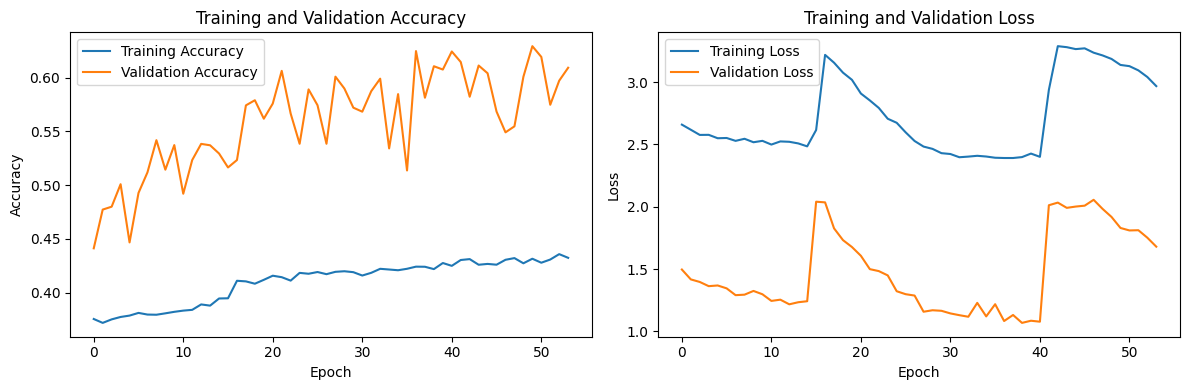

In [103]:
import matplotlib.pyplot as plt


accuracy = historyEnsemble.history['accuracy']
loss = historyEnsemble.history['loss']
val_accuracy = historyEnsemble.history['val_accuracy']
val_loss = historyEnsemble.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Ensamble 3 modelos con pesos promediados.

- Model 1 CNN propuesto Keras tuner 64 batch: 71.32%
- Model 2 CNN Paper: 71.03%, 
- Model 3 CNN propuesto Keras tuner 128 batch: 75.48% 

In [31]:
# Model 1 71.32%
model_1 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)

#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output)


#Model 3 75.48%
model_3 = load_model('models/modelKerasTuner/128batch/best_model_modelKerasTuner_186_0.7548.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

In [32]:
# Concadenar modelos

models = [model_1, model_2, model_3] #se concadena todo en uno

model_input = Input(shape=(48,48,3)) #se define la entrada
model_outputs = [model(model_input) for model in models] #se ingresa la entrada a cada modelo
dropout_outputs = [Dropout(0.25)(output) for output in model_outputs]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output = Average()(dropout_outputs)

#Se define el modelo final
ensemble_model = Model(inputs = model_input, outputs=ensemble_output)

ensemble_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ensemble_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_10 (Functional)          (None, 7)            5924615     ['input_7[0][0]']                
                                                                                                  
 model_11 (Functional)          (None, 7)            1204935     ['input_7[0][0]']                
                                                                                                  
 model_12 (Functional)          (None, 7)            5924615     ['input_7[0][0]']                
                                                                                           

In [35]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/3ModelsMenosParametros/64batch', exist_ok=True)


saved_model_path = 'models/historyEnsemble2/best_model_saved_model/'


checkpoint_callback = ModelCheckpoint(
    saved_model_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # Guardar el modelo completo como SavedModel
    mode='max',
    verbose=1
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/3ModelsMenosParametros/64batch', exist_ok=True)



log_dir = "logs/ModelEnsamble/3ModelsMenosParametros/64batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
historyEnsembleMenor = ensemble_model.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, tensorboard_callback,checkpoint_callback]

)

Epoch 1/300
335/335 [==============================] - ETA: 0s - loss: 1.3359 - accuracy: 0.6130
Epoch 1: val_accuracy improved from -inf to 0.57638, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 145s 424ms/step - loss: 1.3359 - accuracy: 0.6130 - val_loss: 1.2181 - val_accuracy: 0.5764
Epoch 2/300
335/335 [==============================] - ETA: 0s - loss: 1.3570 - accuracy: 0.5994
Epoch 2: val_accuracy improved from 0.57638 to 0.60140, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 418ms/step - loss: 1.3570 - accuracy: 0.5994 - val_loss: 1.2159 - val_accuracy: 0.6014
Epoch 3/300
335/335 [==============================] - ETA: 0s - loss: 1.3555 - accuracy: 0.6030
Epoch 3: val_accuracy improved from 0.60140 to 0.62465, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 421ms/step - loss: 1.3555 - accuracy: 0.6030 - val_loss: 1.1806 - val_accuracy: 0.6246
Epoch 4/300
335/335 [==============================] - ETA: 0s - loss: 1.3385 - accuracy: 0.6079
Epoch 4: val_accuracy did not improve from 0.62465
335/335 [==============================] - 130s 388ms/step - loss: 1.3385 - accuracy: 0.6079 - val_loss: 1.1433 - val_accuracy: 0.5889
Epoch 5/300
335/335 [==============================] - ETA: 0s - loss: 1.3488 - accuracy: 0.6135
Epoch 5: val_accuracy improved from 0.62465 to 0.67619, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 421ms/step - loss: 1.3488 - accuracy: 0.6135 - val_loss: 1.0955 - val_accuracy: 0.6762
Epoch 6/300
335/335 [==============================] - ETA: 0s - loss: 1.3202 - accuracy: 0.6129
Epoch 6: val_accuracy did not improve from 0.67619
335/335 [==============================] - 130s 387ms/step - loss: 1.3202 - accuracy: 0.6129 - val_loss: 1.1008 - val_accuracy: 0.6419
Epoch 7/300
335/335 [==============================] - ETA: 0s - loss: 1.3199 - accuracy: 0.6149
Epoch 7: val_accuracy did not improve from 0.67619
335/335 [==============================] - 130s 387ms/step - loss: 1.3199 - accuracy: 0.6149 - val_loss: 1.0775 - val_accuracy: 0.6302
Epoch 8/300
335/335 [==============================] - ETA: 0s - loss: 1.3228 - accuracy: 0.6126
Epoch 8: val_accuracy did not improve from 0.67619
335/335 [==============================] - 129s 386ms/step - loss: 1.3228 - accuracy: 0.6126 - val_loss: 1.0807 - val_accuracy: 0.6638
Epoch 9/300
335/

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 418ms/step - loss: 1.2936 - accuracy: 0.6264 - val_loss: 0.9466 - val_accuracy: 0.6793
Epoch 18/300
335/335 [==============================] - ETA: 0s - loss: 1.2915 - accuracy: 0.6246
Epoch 18: val_accuracy did not improve from 0.67927
335/335 [==============================] - 129s 385ms/step - loss: 1.2915 - accuracy: 0.6246 - val_loss: 0.9790 - val_accuracy: 0.6711
Epoch 19/300
335/335 [==============================] - ETA: 0s - loss: 1.2933 - accuracy: 0.6235
Epoch 19: val_accuracy did not improve from 0.67927
335/335 [==============================] - 130s 387ms/step - loss: 1.2933 - accuracy: 0.6235 - val_loss: 1.0778 - val_accuracy: 0.6495
Epoch 20/300
335/335 [==============================] - ETA: 0s - loss: 1.2815 - accuracy: 0.6262
Epoch 20: val_accuracy did not improve from 0.67927
335/335 [==============================] - 131s 392ms/step - loss: 1.2815 - accuracy: 0.6262 - val_loss: 1.0023 - val_accuracy: 0.6523
Epoch 21/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 176s 526ms/step - loss: 1.2618 - accuracy: 0.6270 - val_loss: 1.0196 - val_accuracy: 0.6840
Epoch 23/300
335/335 [==============================] - ETA: 0s - loss: 1.2702 - accuracy: 0.6319
Epoch 23: val_accuracy did not improve from 0.68403
335/335 [==============================] - 180s 535ms/step - loss: 1.2702 - accuracy: 0.6319 - val_loss: 0.9018 - val_accuracy: 0.6814
Epoch 24/300
335/335 [==============================] - ETA: 0s - loss: 1.2570 - accuracy: 0.6320
Epoch 24: val_accuracy did not improve from 0.68403
335/335 [==============================] - 159s 474ms/step - loss: 1.2570 - accuracy: 0.6320 - val_loss: 1.0395 - val_accuracy: 0.6623
Epoch 25/300
335/335 [==============================] - ETA: 0s - loss: 1.2696 - accuracy: 0.6314
Epoch 25: val_accuracy did not improve from 0.68403
335/335 [==============================] - 158s 471ms/step - loss: 1.2696 - accuracy: 0.6314 - val_loss: 1.0340 - val_accuracy: 0.6340
Epoch 26/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 143s 426ms/step - loss: 1.2594 - accuracy: 0.6320 - val_loss: 0.9041 - val_accuracy: 0.6858
Epoch 28/300
335/335 [==============================] - ETA: 0s - loss: 1.2543 - accuracy: 0.6335
Epoch 28: val_accuracy did not improve from 0.68581
335/335 [==============================] - 133s 396ms/step - loss: 1.2543 - accuracy: 0.6335 - val_loss: 0.9608 - val_accuracy: 0.6657
Epoch 29/300
335/335 [==============================] - ETA: 0s - loss: 1.2688 - accuracy: 0.6306
Epoch 29: val_accuracy did not improve from 0.68581
335/335 [==============================] - 132s 393ms/step - loss: 1.2688 - accuracy: 0.6306 - val_loss: 1.0953 - val_accuracy: 0.6498
Epoch 30/300
335/335 [==============================] - ETA: 0s - loss: 1.2450 - accuracy: 0.6358
Epoch 30: val_accuracy did not improve from 0.68581
335/335 [==============================] - 133s 395ms/step - loss: 1.2450 - accuracy: 0.6358 - val_loss: 0.9723 - val_accuracy: 0.6738
Epoch 31/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 418ms/step - loss: 1.2578 - accuracy: 0.6353 - val_loss: 0.9109 - val_accuracy: 0.6951
Epoch 33/300
335/335 [==============================] - ETA: 0s - loss: 1.2350 - accuracy: 0.6360
Epoch 33: val_accuracy did not improve from 0.69514
335/335 [==============================] - 131s 391ms/step - loss: 1.2350 - accuracy: 0.6360 - val_loss: 0.9432 - val_accuracy: 0.6786
Epoch 34/300
335/335 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.6374
Epoch 34: val_accuracy did not improve from 0.69514
335/335 [==============================] - 133s 397ms/step - loss: 1.2446 - accuracy: 0.6374 - val_loss: 0.8750 - val_accuracy: 0.6888
Epoch 35/300
335/335 [==============================] - ETA: 0s - loss: 1.2484 - accuracy: 0.6346
Epoch 35: val_accuracy did not improve from 0.69514
335/335 [==============================] - 138s 412ms/step - loss: 1.2484 - accuracy: 0.6346 - val_loss: 0.9245 - val_accuracy: 0.6720
Epoch 36/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 420ms/step - loss: 1.2151 - accuracy: 0.6465 - val_loss: 0.8568 - val_accuracy: 0.6962
Epoch 46/300
335/335 [==============================] - ETA: 0s - loss: 1.2260 - accuracy: 0.6507
Epoch 46: val_accuracy did not improve from 0.69617
335/335 [==============================] - 130s 389ms/step - loss: 1.2260 - accuracy: 0.6507 - val_loss: 0.9390 - val_accuracy: 0.6758
Epoch 47/300
335/335 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 0.6479
Epoch 47: val_accuracy did not improve from 0.69617
335/335 [==============================] - 130s 389ms/step - loss: 1.2074 - accuracy: 0.6479 - val_loss: 0.8908 - val_accuracy: 0.6825
Epoch 48/300
335/335 [==============================] - ETA: 0s - loss: 1.2395 - accuracy: 0.6454
Epoch 48: val_accuracy did not improve from 0.69617
335/335 [==============================] - 130s 389ms/step - loss: 1.2395 - accuracy: 0.6454 - val_loss: 0.8678 - val_accuracy: 0.6902
Epoch 49/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 419ms/step - loss: 1.1770 - accuracy: 0.6564 - val_loss: 0.8334 - val_accuracy: 0.6996
Epoch 56/300
335/335 [==============================] - ETA: 0s - loss: 1.1861 - accuracy: 0.6541
Epoch 56: val_accuracy did not improve from 0.69963
335/335 [==============================] - 131s 389ms/step - loss: 1.1861 - accuracy: 0.6541 - val_loss: 0.8459 - val_accuracy: 0.6982
Epoch 57/300
335/335 [==============================] - ETA: 0s - loss: 1.2051 - accuracy: 0.6530
Epoch 57: val_accuracy did not improve from 0.69963
335/335 [==============================] - 131s 391ms/step - loss: 1.2051 - accuracy: 0.6530 - val_loss: 0.9204 - val_accuracy: 0.6893
Epoch 58/300
335/335 [==============================] - ETA: 0s - loss: 1.1777 - accuracy: 0.6550
Epoch 58: val_accuracy did not improve from 0.69963
335/335 [==============================] - 130s 389ms/step - loss: 1.1777 - accuracy: 0.6550 - val_loss: 0.8949 - val_accuracy: 0.6883
Epoch 59/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 142s 422ms/step - loss: 1.1654 - accuracy: 0.6589 - val_loss: 0.8373 - val_accuracy: 0.7010
Epoch 65/300
335/335 [==============================] - ETA: 0s - loss: 1.1903 - accuracy: 0.6586
Epoch 65: val_accuracy did not improve from 0.70103
335/335 [==============================] - 131s 392ms/step - loss: 1.1903 - accuracy: 0.6586 - val_loss: 0.8625 - val_accuracy: 0.6912
Epoch 66/300
335/335 [==============================] - ETA: 0s - loss: 1.1649 - accuracy: 0.6616
Epoch 66: val_accuracy improved from 0.70103 to 0.70289, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 142s 424ms/step - loss: 1.1649 - accuracy: 0.6616 - val_loss: 0.8228 - val_accuracy: 0.7029
Epoch 67/300
335/335 [==============================] - ETA: 0s - loss: 1.1762 - accuracy: 0.6612
Epoch 67: val_accuracy did not improve from 0.70289
335/335 [==============================] - 132s 393ms/step - loss: 1.1762 - accuracy: 0.6612 - val_loss: 0.8639 - val_accuracy: 0.6911
Epoch 68/300
335/335 [==============================] - ETA: 0s - loss: 1.1616 - accuracy: 0.6618
Epoch 68: val_accuracy did not improve from 0.70289
335/335 [==============================] - 132s 393ms/step - loss: 1.1616 - accuracy: 0.6618 - val_loss: 0.8712 - val_accuracy: 0.7001
Epoch 69/300
335/335 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.6606
Epoch 69: val_accuracy improved from 0.70289 to 0.70794, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 422ms/step - loss: 1.1481 - accuracy: 0.6606 - val_loss: 0.8246 - val_accuracy: 0.7079
Epoch 70/300
335/335 [==============================] - ETA: 0s - loss: 1.1671 - accuracy: 0.6642
Epoch 70: val_accuracy did not improve from 0.70794
335/335 [==============================] - 132s 394ms/step - loss: 1.1671 - accuracy: 0.6642 - val_loss: 0.8828 - val_accuracy: 0.6968
Epoch 71/300
335/335 [==============================] - ETA: 0s - loss: 1.1695 - accuracy: 0.6623
Epoch 71: val_accuracy did not improve from 0.70794
335/335 [==============================] - 131s 391ms/step - loss: 1.1695 - accuracy: 0.6623 - val_loss: 0.8270 - val_accuracy: 0.7061
Epoch 72/300
335/335 [==============================] - ETA: 0s - loss: 1.1586 - accuracy: 0.6652
Epoch 72: val_accuracy did not improve from 0.70794
335/335 [==============================] - 131s 391ms/step - loss: 1.1586 - accuracy: 0.6652 - val_loss: 0.8658 - val_accuracy: 0.6903
Epoch 73/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 421ms/step - loss: 1.1526 - accuracy: 0.6655 - val_loss: 0.8008 - val_accuracy: 0.7108
Epoch 80/300
335/335 [==============================] - ETA: 0s - loss: 1.1462 - accuracy: 0.6680
Epoch 80: val_accuracy did not improve from 0.71083
335/335 [==============================] - 130s 389ms/step - loss: 1.1462 - accuracy: 0.6680 - val_loss: 0.8088 - val_accuracy: 0.7085
Epoch 81/300
335/335 [==============================] - ETA: 0s - loss: 1.1597 - accuracy: 0.6666
Epoch 81: val_accuracy did not improve from 0.71083
335/335 [==============================] - 131s 390ms/step - loss: 1.1597 - accuracy: 0.6666 - val_loss: 0.8635 - val_accuracy: 0.6968
Epoch 82/300
335/335 [==============================] - ETA: 0s - loss: 1.1423 - accuracy: 0.6678
Epoch 82: val_accuracy did not improve from 0.71083
335/335 [==============================] - 131s 389ms/step - loss: 1.1423 - accuracy: 0.6678 - val_loss: 0.8307 - val_accuracy: 0.7038
Epoch 83/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 141s 420ms/step - loss: 1.1349 - accuracy: 0.6724 - val_loss: 0.8001 - val_accuracy: 0.7119
Epoch 87/300
335/335 [==============================] - ETA: 0s - loss: 1.1386 - accuracy: 0.6718
Epoch 87: val_accuracy did not improve from 0.71186
335/335 [==============================] - 130s 387ms/step - loss: 1.1386 - accuracy: 0.6718 - val_loss: 0.8364 - val_accuracy: 0.6979
Epoch 88/300
335/335 [==============================] - ETA: 0s - loss: 1.1277 - accuracy: 0.6750
Epoch 88: val_accuracy did not improve from 0.71186
335/335 [==============================] - 129s 385ms/step - loss: 1.1277 - accuracy: 0.6750 - val_loss: 0.8131 - val_accuracy: 0.7090
Epoch 89/300
335/335 [==============================] - ETA: 0s - loss: 1.1238 - accuracy: 0.6722
Epoch 89: val_accuracy did not improve from 0.71186
335/335 [==============================] - 130s 387ms/step - loss: 1.1238 - accuracy: 0.6722 - val_loss: 0.8128 - val_accuracy: 0.7038
Epoch 90/3

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 139s 415ms/step - loss: 1.1062 - accuracy: 0.6771 - val_loss: 0.7815 - val_accuracy: 0.7148
Epoch 101/300
335/335 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.6780
Epoch 101: val_accuracy did not improve from 0.71475
335/335 [==============================] - 129s 385ms/step - loss: 1.1205 - accuracy: 0.6780 - val_loss: 0.8031 - val_accuracy: 0.7095
Epoch 102/300
335/335 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.6790
Epoch 102: val_accuracy did not improve from 0.71475
335/335 [==============================] - 129s 383ms/step - loss: 1.1110 - accuracy: 0.6790 - val_loss: 0.7926 - val_accuracy: 0.7145
Epoch 103/300
335/335 [==============================] - ETA: 0s - loss: 1.1223 - accuracy: 0.6768
Epoch 103: val_accuracy did not improve from 0.71475
335/335 [==============================] - 129s 384ms/step - loss: 1.1223 - accuracy: 0.6768 - val_loss: 0.8419 - val_accuracy: 0.6969
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 139s 413ms/step - loss: 1.1060 - accuracy: 0.6820 - val_loss: 0.7884 - val_accuracy: 0.7159
Epoch 110/300
335/335 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.6814
Epoch 110: val_accuracy did not improve from 0.71587
335/335 [==============================] - 130s 386ms/step - loss: 1.1078 - accuracy: 0.6814 - val_loss: 0.7864 - val_accuracy: 0.7130
Epoch 111/300
335/335 [==============================] - ETA: 0s - loss: 1.0979 - accuracy: 0.6840
Epoch 111: val_accuracy did not improve from 0.71587
335/335 [==============================] - 130s 386ms/step - loss: 1.0979 - accuracy: 0.6840 - val_loss: 0.8144 - val_accuracy: 0.7091
Epoch 112/300
335/335 [==============================] - ETA: 0s - loss: 1.1066 - accuracy: 0.6812
Epoch 112: val_accuracy did not improve from 0.71587
335/335 [==============================] - 130s 386ms/step - loss: 1.1066 - accuracy: 0.6812 - val_loss: 0.8173 - val_accuracy: 0.7069
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 419ms/step - loss: 1.1079 - accuracy: 0.6831 - val_loss: 0.7937 - val_accuracy: 0.7198
Epoch 116/300
335/335 [==============================] - ETA: 0s - loss: 1.0958 - accuracy: 0.6876
Epoch 116: val_accuracy did not improve from 0.71979
335/335 [==============================] - 130s 388ms/step - loss: 1.0958 - accuracy: 0.6876 - val_loss: 0.8045 - val_accuracy: 0.7155
Epoch 117/300
335/335 [==============================] - ETA: 0s - loss: 1.0958 - accuracy: 0.6844
Epoch 117: val_accuracy did not improve from 0.71979
335/335 [==============================] - 130s 388ms/step - loss: 1.0958 - accuracy: 0.6844 - val_loss: 0.8042 - val_accuracy: 0.7167
Epoch 118/300
335/335 [==============================] - ETA: 0s - loss: 1.0831 - accuracy: 0.6877
Epoch 118: val_accuracy did not improve from 0.71979
335/335 [==============================] - 130s 388ms/step - loss: 1.0831 - accuracy: 0.6877 - val_loss: 0.7797 - val_accuracy: 0.7197
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 417ms/step - loss: 1.0752 - accuracy: 0.6878 - val_loss: 0.7664 - val_accuracy: 0.7261
Epoch 129/300
335/335 [==============================] - ETA: 0s - loss: 1.0774 - accuracy: 0.6889
Epoch 129: val_accuracy did not improve from 0.72605
335/335 [==============================] - 130s 388ms/step - loss: 1.0774 - accuracy: 0.6889 - val_loss: 0.7849 - val_accuracy: 0.7138
Epoch 130/300
335/335 [==============================] - ETA: 0s - loss: 1.0951 - accuracy: 0.6883
Epoch 130: val_accuracy did not improve from 0.72605
335/335 [==============================] - 130s 387ms/step - loss: 1.0951 - accuracy: 0.6883 - val_loss: 0.7636 - val_accuracy: 0.7247
Epoch 131/300
335/335 [==============================] - ETA: 0s - loss: 1.0698 - accuracy: 0.6897
Epoch 131: val_accuracy did not improve from 0.72605
335/335 [==============================] - 129s 386ms/step - loss: 1.0698 - accuracy: 0.6897 - val_loss: 0.7922 - val_accuracy: 0.7132
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 139s 416ms/step - loss: 1.0653 - accuracy: 0.6944 - val_loss: 0.7530 - val_accuracy: 0.7269
Epoch 143/300
335/335 [==============================] - ETA: 0s - loss: 1.0739 - accuracy: 0.6962
Epoch 143: val_accuracy did not improve from 0.72689
335/335 [==============================] - 129s 385ms/step - loss: 1.0739 - accuracy: 0.6962 - val_loss: 0.8143 - val_accuracy: 0.7072
Epoch 144/300
335/335 [==============================] - ETA: 0s - loss: 1.0710 - accuracy: 0.6936
Epoch 144: val_accuracy did not improve from 0.72689
335/335 [==============================] - 131s 390ms/step - loss: 1.0710 - accuracy: 0.6936 - val_loss: 0.8018 - val_accuracy: 0.7144
Epoch 145/300
335/335 [==============================] - ETA: 0s - loss: 1.0800 - accuracy: 0.6924
Epoch 145: val_accuracy did not improve from 0.72689
335/335 [==============================] - 130s 389ms/step - loss: 1.0800 - accuracy: 0.6924 - val_loss: 0.7975 - val_accuracy: 0.7160
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 417ms/step - loss: 1.0628 - accuracy: 0.6974 - val_loss: 0.7594 - val_accuracy: 0.7273
Epoch 160/300
335/335 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.7025
Epoch 160: val_accuracy improved from 0.72726 to 0.72801, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 419ms/step - loss: 1.0429 - accuracy: 0.7025 - val_loss: 0.7435 - val_accuracy: 0.7280
Epoch 161/300
335/335 [==============================] - ETA: 0s - loss: 1.0601 - accuracy: 0.6995
Epoch 161: val_accuracy did not improve from 0.72801
335/335 [==============================] - 130s 389ms/step - loss: 1.0601 - accuracy: 0.6995 - val_loss: 0.7745 - val_accuracy: 0.7186
Epoch 162/300
335/335 [==============================] - ETA: 0s - loss: 1.0485 - accuracy: 0.7009
Epoch 162: val_accuracy did not improve from 0.72801
335/335 [==============================] - 130s 387ms/step - loss: 1.0485 - accuracy: 0.7009 - val_loss: 0.7900 - val_accuracy: 0.7110
Epoch 163/300
335/335 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.7023
Epoch 163: val_accuracy did not improve from 0.72801
335/335 [==============================] - 129s 385ms/step - loss: 1.0536 - accuracy: 0.7023 - val_loss: 0.7646 - val_accuracy: 0.7237
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 139s 415ms/step - loss: 1.0642 - accuracy: 0.6995 - val_loss: 0.7472 - val_accuracy: 0.7308
Epoch 165/300
335/335 [==============================] - ETA: 0s - loss: 1.0658 - accuracy: 0.7009
Epoch 165: val_accuracy did not improve from 0.73081
335/335 [==============================] - 129s 386ms/step - loss: 1.0658 - accuracy: 0.7009 - val_loss: 0.7803 - val_accuracy: 0.7208
Epoch 166/300
335/335 [==============================] - ETA: 0s - loss: 1.0581 - accuracy: 0.7038
Epoch 166: val_accuracy did not improve from 0.73081
335/335 [==============================] - 129s 385ms/step - loss: 1.0581 - accuracy: 0.7038 - val_loss: 0.8351 - val_accuracy: 0.6969
Epoch 167/300
335/335 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.7024
Epoch 167: val_accuracy did not improve from 0.73081
335/335 [==============================] - 129s 386ms/step - loss: 1.0486 - accuracy: 0.7024 - val_loss: 0.7645 - val_accuracy: 0.7245
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 139s 415ms/step - loss: 1.0282 - accuracy: 0.7052 - val_loss: 0.7298 - val_accuracy: 0.7359
Epoch 176/300
335/335 [==============================] - ETA: 0s - loss: 1.0692 - accuracy: 0.7011
Epoch 176: val_accuracy did not improve from 0.73585
335/335 [==============================] - 130s 388ms/step - loss: 1.0692 - accuracy: 0.7011 - val_loss: 0.7415 - val_accuracy: 0.7303
Epoch 177/300
335/335 [==============================] - ETA: 0s - loss: 1.0325 - accuracy: 0.7040
Epoch 177: val_accuracy did not improve from 0.73585
335/335 [==============================] - 130s 389ms/step - loss: 1.0325 - accuracy: 0.7040 - val_loss: 0.7816 - val_accuracy: 0.7215
Epoch 178/300
335/335 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.7072
Epoch 178: val_accuracy improved from 0.73585 to 0.73922, saving model to models/historyEnsemble2/best_model_saved_model\


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 140s 418ms/step - loss: 1.0352 - accuracy: 0.7072 - val_loss: 0.7282 - val_accuracy: 0.7392
Epoch 179/300
335/335 [==============================] - ETA: 0s - loss: 1.0407 - accuracy: 0.7061
Epoch 179: val_accuracy did not improve from 0.73922
335/335 [==============================] - 129s 382ms/step - loss: 1.0407 - accuracy: 0.7061 - val_loss: 0.7449 - val_accuracy: 0.7331
Epoch 180/300
335/335 [==============================] - ETA: 0s - loss: 1.0404 - accuracy: 0.7074
Epoch 180: val_accuracy did not improve from 0.73922
335/335 [==============================] - 127s 380ms/step - loss: 1.0404 - accuracy: 0.7074 - val_loss: 0.7523 - val_accuracy: 0.7294
Epoch 181/300
335/335 [==============================] - ETA: 0s - loss: 1.0347 - accuracy: 0.7050
Epoch 181: val_accuracy did not improve from 0.73922
335/335 [==============================] - 128s 381ms/step - loss: 1.0347 - accuracy: 0.7050 - val_loss: 0.7165 - val_accuracy: 0.7377
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 138s 412ms/step - loss: 1.0228 - accuracy: 0.7111 - val_loss: 0.7184 - val_accuracy: 0.7410
Epoch 189/300
335/335 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.7059
Epoch 189: val_accuracy did not improve from 0.74099
335/335 [==============================] - 128s 381ms/step - loss: 1.0352 - accuracy: 0.7059 - val_loss: 0.7285 - val_accuracy: 0.7381
Epoch 190/300
335/335 [==============================] - ETA: 0s - loss: 1.0353 - accuracy: 0.7092
Epoch 190: val_accuracy did not improve from 0.74099
335/335 [==============================] - 128s 382ms/step - loss: 1.0353 - accuracy: 0.7092 - val_loss: 0.7558 - val_accuracy: 0.7336
Epoch 191/300
335/335 [==============================] - ETA: 0s - loss: 1.0259 - accuracy: 0.7061
Epoch 191: val_accuracy did not improve from 0.74099
335/335 [==============================] - 128s 383ms/step - loss: 1.0259 - accuracy: 0.7061 - val_loss: 0.7445 - val_accuracy: 0.7351
Epoc

INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


INFO:tensorflow:Assets written to: models/historyEnsemble2/best_model_saved_model\assets


335/335 [==============================] - 138s 411ms/step - loss: 1.0225 - accuracy: 0.7100 - val_loss: 0.7241 - val_accuracy: 0.7418
Epoch 199/300
335/335 [==============================] - ETA: 0s - loss: 1.0406 - accuracy: 0.7107
Epoch 199: val_accuracy did not improve from 0.74183
335/335 [==============================] - 128s 383ms/step - loss: 1.0406 - accuracy: 0.7107 - val_loss: 0.8005 - val_accuracy: 0.7130
Epoch 200/300
335/335 [==============================] - ETA: 0s - loss: 1.0354 - accuracy: 0.7076
Epoch 200: val_accuracy did not improve from 0.74183
335/335 [==============================] - 128s 381ms/step - loss: 1.0354 - accuracy: 0.7076 - val_loss: 0.7609 - val_accuracy: 0.7252
Epoch 201/300
335/335 [==============================] - ETA: 0s - loss: 1.0340 - accuracy: 0.7133
Epoch 201: val_accuracy did not improve from 0.74183
335/335 [==============================] - 128s 383ms/step - loss: 1.0340 - accuracy: 0.7133 - val_loss: 0.7748 - val_accuracy: 0.7221


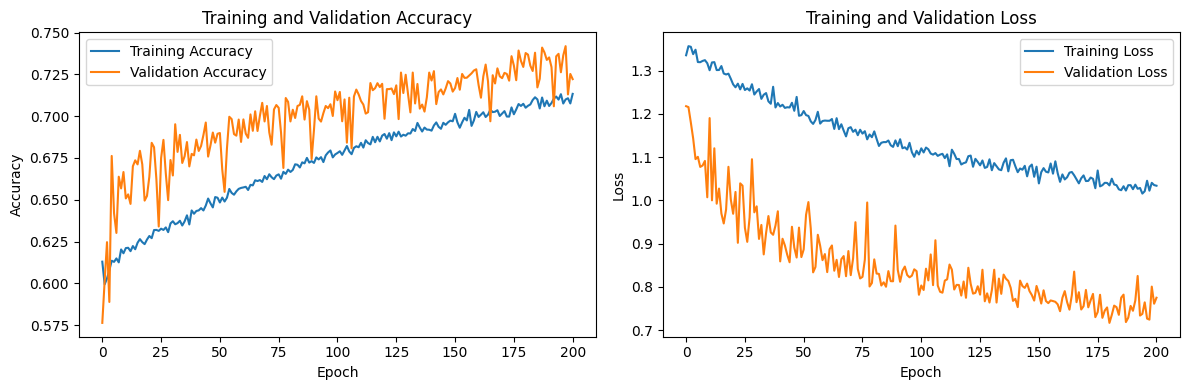

In [37]:
import matplotlib.pyplot as plt


accuracy = historyEnsembleMenor.history['accuracy']
loss = historyEnsembleMenor.history['loss']
val_accuracy = historyEnsembleMenor.history['val_accuracy']
val_loss = historyEnsembleMenor.history['val_loss']

# Graficar la precisión (accuracy)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Graficar la pérdida (loss)
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Ensamble 2 modelos con pesos promediados.

Unión del modelo propuesto con diferentes batches
- Model 1 CNN propuesto Keras tuner 64 batch: 71.32% 
- Model 2 CNN propuesto Keras tuner 128 batch: 75.48% 



In [38]:
# Model 1 71.32%
model_1 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_1 = Model(inputs = model_1.inputs, outputs=model_1.output)


#Model 3 75.48%
model_3 = load_model('models/modelKerasTuner/128batch/best_model_modelKerasTuner_186_0.7548.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output)

In [39]:
# Concadenar modelos

models2 = [model_1, model_3] #se concadena todo en uno

model_input2 = Input(shape=(48,48,3)) #se define la entrada
model_outputs2 = [model(model_input2) for model in models2] #se ingresa la entrada a cada modelo
dropout_outputs = [Dropout(0.3)(output) for output in model_outputs2]

#Se define que se desarrolle el ensamble mediante el promedio de los 2
ensemble_output2 = Average()(dropout_outputs)

#Se define el modelo final
EnsembleMenor2 = Model(inputs = model_input2, outputs=ensemble_output2)

EnsembleMenor2.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=["accuracy"])

EnsembleMenor2.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_14 (Functional)          (None, 7)            5924615     ['input_8[0][0]']                
                                                                                                  
 model_15 (Functional)          (None, 7)            5924615     ['input_8[0][0]']                
                                                                                                  
 dropout_18 (Dropout)           (None, 7)            0           ['model_14[0][0]']               
                                                                                           

In [40]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/2ModelsMenosParametros/128batch', exist_ok=True)

checkpoint_path = 'models/ModelEnsamble/2ModelsMenosParametros/128batch/best_model_Model_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint2 = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='max',               # Modo 'max' significa guardar el modelo cuando la métrica monitor alcanza su máximo
    verbose=1                 # Muestra información detallada
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/2ModelsMenosParametros/128batch', exist_ok=True)


log_dir = "logs/ModelEnsamble/2ModelsMenosParametros/128batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
historyEnsembleMenor2 = EnsembleMenor2.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint2, tensorboard_callback]

)

Epoch 1/300
335/335 [==============================] - ETA: 0s - loss: 2.1049 - accuracy: 0.6773
Epoch 1: val_accuracy improved from -inf to 0.72969, saving model to models/ModelEnsamble/2ModelsMenosParametros/128batch\best_model_Model_1_0.7297.h5
335/335 [==============================] - 154s 456ms/step - loss: 2.1049 - accuracy: 0.6773 - val_loss: 0.7514 - val_accuracy: 0.7297
Epoch 2/300
335/335 [==============================] - ETA: 0s - loss: 2.0922 - accuracy: 0.6766
Epoch 2: val_accuracy did not improve from 0.72969
335/335 [==============================] - 121s 359ms/step - loss: 2.0922 - accuracy: 0.6766 - val_loss: 0.7564 - val_accuracy: 0.7295
Epoch 3/300
335/335 [==============================] - ETA: 0s - loss: 2.0252 - accuracy: 0.6853
Epoch 3: val_accuracy improved from 0.72969 to 0.73838, saving model to models/ModelEnsamble/2ModelsMenosParametros/128batch\best_model_Model_3_0.7384.h5
335/335 [==============================] - 117s 348ms/step - loss: 2.0252 - accurac

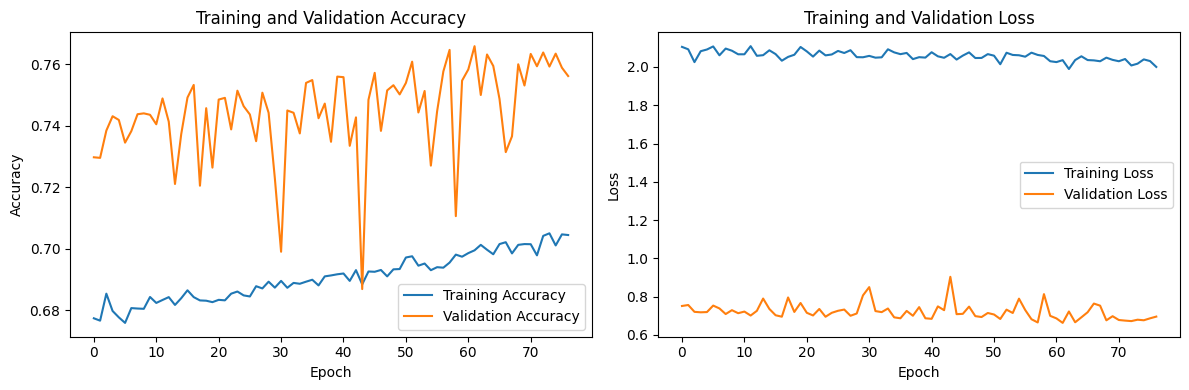

In [42]:
import matplotlib.pyplot as plt


accuracy = historyEnsembleMenor2.history['accuracy']
loss = historyEnsembleMenor2.history['loss']
val_accuracy = historyEnsembleMenor2.history['val_accuracy']
val_loss = historyEnsembleMenor2.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Ensamble 2 modelos con pesos promediados.

- Model 2 CNN Paper: 71.03%, 
- Model 3 CNN Keras tuner 64 batch: 71.32% 

In [58]:
#Modelos
from keras.models import Model, load_model
from keras.layers import Input, Average, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam

In [59]:
#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')

In [62]:
# Concadenar modelos

models2 = [model_2, model_3] #se concadena todo en uno

model_input2 = Input(shape=(48,48,3)) #se define la entrada
model_outputs2 = [model(model_input2) for model in models2] #se ingresa la entrada a cada modelo
dropout_outputs = [Dropout(0.3)(output) for output in model_outputs2]

#Se define que se desarrolle el ensamble mediante el promedio de los 3
ensemble_output2 = Average()(dropout_outputs)

#Se define el modelo final
ensemble_model2Dropout = Model(inputs = model_input2, outputs=ensemble_output2, name="ensemble_model")

ensemble_model2Dropout.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=["accuracy"])

ensemble_model2Dropout.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_13[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_13[0][0]']               
                                                                                                  
 dropout_12 (Dropout)           (None, 7)            0           ['model_2[1][0]']                
                                                                                     

In [61]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/2ModelsDropout/64batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/2ModelsDropout/64batch/best_model_2ModelsDropout_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='max',               # Modo 'max' significa guardar el modelo cuando la métrica monitor alcanza su máximo
    verbose=1                 # Muestra información detallada
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/2ModelsDropout/64batch', exist_ok=True)



log_dir = "logs/ModelEnsamble/2ModelsDropout/64batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [63]:
historyEnsemble2ModelsDropout = ensemble_model2Dropout.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]

)

Epoch 1/300
670/670 [==============================] - ETA: 0s - loss: 2.1572 - accuracy: 0.6514
Epoch 1: val_accuracy improved from -inf to 0.71578, saving model to models/ModelEnsamble/2ModelsDropout/64batch\best_model_2ModelsDropout_1_0.7158.h5
670/670 [==============================] - 114s 165ms/step - loss: 2.1572 - accuracy: 0.6514 - val_loss: 0.7701 - val_accuracy: 0.7158
Epoch 2/300
670/670 [==============================] - ETA: 0s - loss: 2.1645 - accuracy: 0.6536
Epoch 2: val_accuracy improved from 0.71578 to 0.72334, saving model to models/ModelEnsamble/2ModelsDropout/64batch\best_model_2ModelsDropout_2_0.7233.h5
670/670 [==============================] - 111s 166ms/step - loss: 2.1645 - accuracy: 0.6536 - val_loss: 0.7556 - val_accuracy: 0.7233
Epoch 3/300
670/670 [==============================] - ETA: 0s - loss: 2.1571 - accuracy: 0.6540
Epoch 3: val_accuracy did not improve from 0.72334
670/670 [==============================] - 109s 163ms/step - loss: 2.1571 - accurac

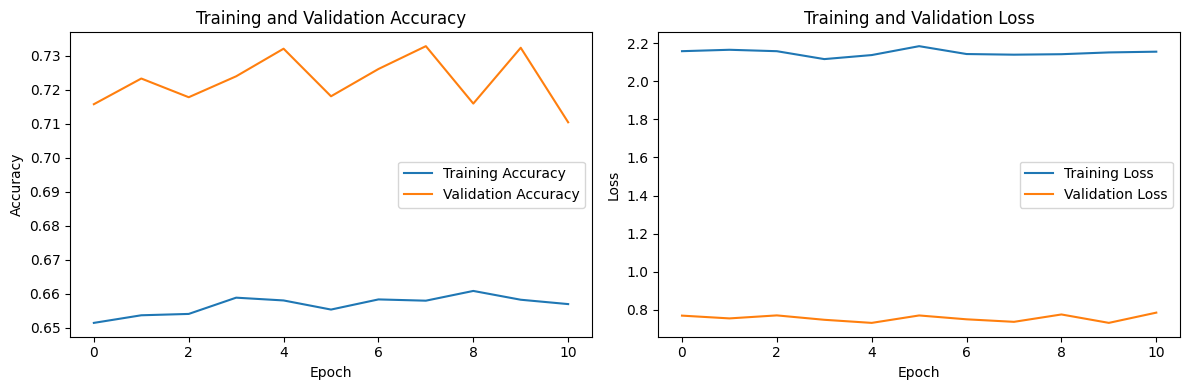

In [70]:
import matplotlib.pyplot as plt


accuracy = historyEnsemble2ModelsDropout.history['accuracy']
loss = historyEnsemble2ModelsDropout.history['loss']
val_accuracy = historyEnsemble2ModelsDropout.history['val_accuracy']
val_loss = historyEnsemble2ModelsDropout.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Con optimizer Adam de 0.001 (Predeterminado)

In [71]:
#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')

In [72]:
# Concadenar modelos

models2 = [model_2, model_3] #se concadena todo en uno

model_input2 = Input(shape=(48,48,3)) #se define la entrada
model_outputs2 = [model(model_input2) for model in models2] #se ingresa la entrada a cada modelo
dropout_outputs = [Dropout(0.2)(output) for output in model_outputs2]

#Se define que se desarrolle el ensamble mediante el promedio de los 2
ensemble_output2 = Average()(model_outputs2)

#Se define el modelo final
ensemble_model2Dropout = Model(inputs = model_input2, outputs=ensemble_output2, name="ensemble_model")

ensemble_model2Dropout.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ensemble_model2Dropout.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_17[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_17[0][0]']               
                                                                                                  
 average_12 (Average)           (None, 7)            0           ['model_2[0][0]',                
                                                                  'model_3[0][0]']   

In [73]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/2ModelsDropoutAdam/64batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/2ModelsDropoutAdam/64batch/best_model_2ModelsDropout_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='max',               # Modo 'max' significa guardar el modelo cuando la métrica monitor alcanza su máximo
    verbose=1                 # Muestra información detallada
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/2ModelsDropoutAdam/64batch', exist_ok=True)


log_dir = "logs/ModelEnsamble/2ModelsDropoutAdam/64batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
historyEnsemble2ModelsDropout = ensemble_model2Dropout.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]

)

Epoch 1/300
670/670 [==============================] - ETA: 0s - loss: 1.0189 - accuracy: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.68254, saving model to models/ModelEnsamble/2ModelsDropoutAdam/64batch\best_model_2ModelsDropout_1_0.6825.h5
670/670 [==============================] - 117s 172ms/step - loss: 1.0189 - accuracy: 0.6310 - val_loss: 1.0891 - val_accuracy: 0.6825
Epoch 2/300
670/670 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.6433
Epoch 2: val_accuracy did not improve from 0.68254
670/670 [==============================] - 111s 165ms/step - loss: 1.0207 - accuracy: 0.6433 - val_loss: 1.1703 - val_accuracy: 0.6338
Epoch 3/300
670/670 [==============================] - ETA: 0s - loss: 1.0117 - accuracy: 0.6551
Epoch 3: val_accuracy did not improve from 0.68254
670/670 [==============================] - 113s 168ms/step - loss: 1.0117 - accuracy: 0.6551 - val_loss: 0.9645 - val_accuracy: 0.6813
Epoch 4/300
670/670 [==========================

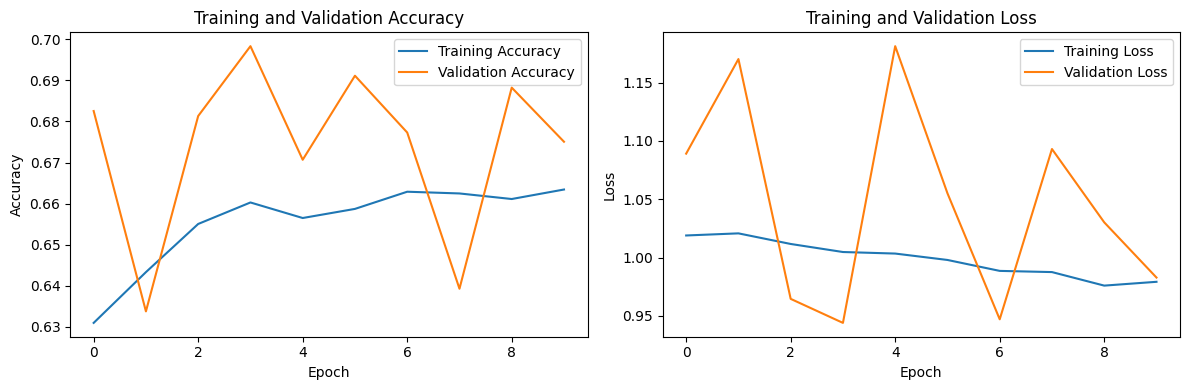

In [75]:
import matplotlib.pyplot as plt


accuracy = historyEnsemble2ModelsDropout.history['accuracy']
loss = historyEnsemble2ModelsDropout.history['loss']
val_accuracy = historyEnsemble2ModelsDropout.history['val_accuracy']
val_loss = historyEnsemble2ModelsDropout.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Con batch_size de 100

In [79]:
# Concadenar modelos

models2 = [model_2, model_3] #se concadena todo en uno

model_input2 = Input(shape=(48,48,3)) #se define la entrada
model_outputs2 = [model(model_input2) for model in models2] #se ingresa la entrada a cada modelo
dropout_outputs = [Dropout(0.3)(output) for output in model_outputs2]

#Se define que se desarrolle el ensamble mediante el promedio de los 2
ensemble_output2 = Average()(dropout_outputs)

#Se define el modelo final
ensemble_model2Dropout = Model(inputs = model_input2, outputs=ensemble_output2, name="ensemble_model")

ensemble_model2Dropout.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=["accuracy"])

ensemble_model2Dropout.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_19[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_19[0][0]']               
                                                                                                  
 dropout_22 (Dropout)           (None, 7)            0           ['model_2[2][0]']                
                                                                                     

In [80]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/2ModelsDropout/100batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/2ModelsDropout/100batch/best_model_2ModelsDropout_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='max',               # Modo 'max' significa guardar el modelo cuando la métrica monitor alcanza su máximo
    verbose=1                 # Muestra información detallada
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/2ModelsDropout/100batch', exist_ok=True)


log_dir = "logs/ModelEnsamble/2ModelsDropout/100batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [81]:
historyEnsemble2ModelsDropout100batch = ensemble_model2Dropout.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]

)

Epoch 1/300
429/429 [==============================] - ETA: 0s - loss: 2.7685 - accuracy: 0.4352
Epoch 1: val_accuracy improved from -inf to 0.68375, saving model to models/ModelEnsamble/2ModelsDropout/100batch\best_model_2ModelsDropout_1_0.6838.h5
429/429 [==============================] - 112s 254ms/step - loss: 2.7685 - accuracy: 0.4352 - val_loss: 0.9174 - val_accuracy: 0.6838
Epoch 2/300
429/429 [==============================] - ETA: 0s - loss: 2.6458 - accuracy: 0.4487
Epoch 2: val_accuracy did not improve from 0.68375
429/429 [==============================] - 107s 250ms/step - loss: 2.6458 - accuracy: 0.4487 - val_loss: 0.9194 - val_accuracy: 0.6795
Epoch 3/300
429/429 [==============================] - ETA: 0s - loss: 2.6637 - accuracy: 0.4554
Epoch 3: val_accuracy did not improve from 0.68375
429/429 [==============================] - 108s 252ms/step - loss: 2.6637 - accuracy: 0.4554 - val_loss: 0.9181 - val_accuracy: 0.6715
Epoch 4/300
429/429 [=============================

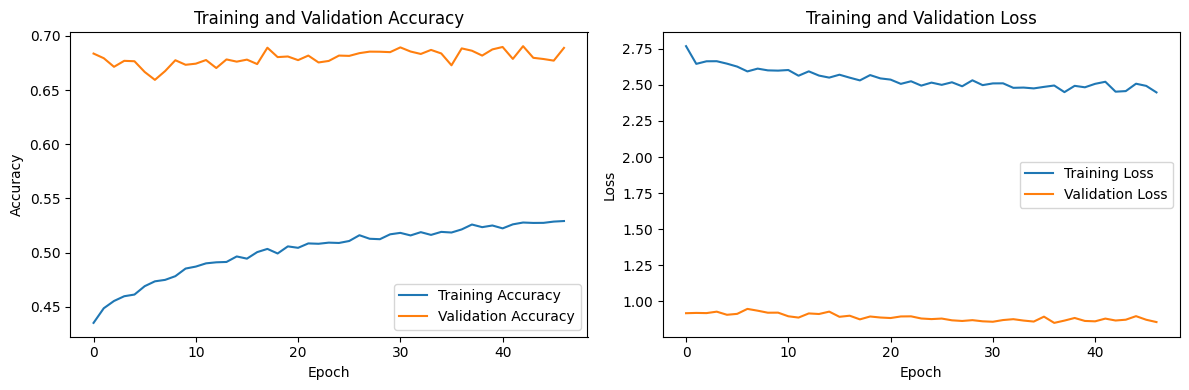

In [82]:
import matplotlib.pyplot as plt


accuracy = historyEnsemble2ModelsDropout100batch.history['accuracy']
loss = historyEnsemble2ModelsDropout100batch.history['loss']
val_accuracy = historyEnsemble2ModelsDropout100batch.history['val_accuracy']
val_loss = historyEnsemble2ModelsDropout100batch.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Ensamble 2 modelos con pesos promediados.

- Model 2 CNN Paper: 71.03%, 
- Model 3 CNN Keras tuner 128 batch: 75.48% 

In [43]:
#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/modelKerasTuner/128batch/best_model_modelKerasTuner_186_0.7548.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')

In [44]:
# Concadenar modelos
modelsEnsembleNew = [model_2, model_3] 

model_input3 = Input(shape=(48,48,3)) #se define la entrada
model_outputs3 = [model(model_input3) for model in modelsEnsembleNew] #se ingresa la entrada a cada modelo

#Se define que se desarrolle el ensamble mediante el promedio de los 2
ensemble_output3 = Average()(model_outputs3)

#Se define el modelo final
ensemble_modelNewt = Model(inputs = model_input3, outputs=ensemble_output3)

ensemble_modelNewt.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ensemble_modelNewt.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_9[0][0]']                
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_9[0][0]']                
                                                                                                  
 average_8 (Average)            (None, 7)            0           ['model_2[0][0]',                
                                                                  'model_3[0][0]']         

In [48]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


os.makedirs('models/ModelEnsamble/EnsmbleNew/128batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/EnsmbleNew/128batch/'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,     
    mode='max',               
    verbose=1                 
)


In [49]:
historyEnsembleNew = ensemble_modelNewt.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/300
335/335 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.6574
Epoch 1: val_accuracy improved from -inf to 0.59599, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 332ms/step - loss: 0.9645 - accuracy: 0.6574 - val_loss: 1.0489 - val_accuracy: 0.5960
Epoch 2/300
335/335 [==============================] - ETA: 0s - loss: 0.9573 - accuracy: 0.6662
Epoch 2: val_accuracy improved from 0.59599 to 0.63100, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 114s 340ms/step - loss: 0.9573 - accuracy: 0.6662 - val_loss: 1.2893 - val_accuracy: 0.6310
Epoch 3/300
335/335 [==============================] - ETA: 0s - loss: 0.9489 - accuracy: 0.6694
Epoch 3: val_accuracy improved from 0.63100 to 0.66527, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 115s 341ms/step - loss: 0.9489 - accuracy: 0.6694 - val_loss: 1.0720 - val_accuracy: 0.6653
Epoch 4/300
335/335 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.6677
Epoch 4: val_accuracy did not improve from 0.66527
335/335 [==============================] - 109s 324ms/step - loss: 0.9486 - accuracy: 0.6677 - val_loss: 0.9812 - val_accuracy: 0.6436
Epoch 5/300
335/335 [==============================] - ETA: 0s - loss: 0.9423 - accuracy: 0.6724
Epoch 5: val_accuracy did not improve from 0.66527
335/335 [==============================] - 109s 325ms/step - loss: 0.9423 - accuracy: 0.6724 - val_loss: 1.0330 - val_accuracy: 0.6216
Epoch 6/300
335/335 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.6702
Epoch 6: val_accuracy did not improve from 0.66527
335/335 [==============================] - 147s 439ms/step - loss: 0.9458 - accuracy: 0.6702 - val_loss: 0.9511 - val_accuracy: 0.6633
Epoch 7/300
335/

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 114s 340ms/step - loss: 0.9383 - accuracy: 0.6682 - val_loss: 0.9539 - val_accuracy: 0.6713
Epoch 8/300
335/335 [==============================] - ETA: 0s - loss: 0.9428 - accuracy: 0.6695
Epoch 8: val_accuracy did not improve from 0.67134
335/335 [==============================] - 105s 314ms/step - loss: 0.9428 - accuracy: 0.6695 - val_loss: 1.0091 - val_accuracy: 0.6675
Epoch 9/300
335/335 [==============================] - ETA: 0s - loss: 0.9408 - accuracy: 0.6711
Epoch 9: val_accuracy did not improve from 0.67134
335/335 [==============================] - 107s 319ms/step - loss: 0.9408 - accuracy: 0.6711 - val_loss: 1.0730 - val_accuracy: 0.6414
Epoch 10/300
335/335 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.6731
Epoch 10: val_accuracy did not improve from 0.67134
335/335 [==============================] - 106s 317ms/step - loss: 0.9336 - accuracy: 0.6731 - val_loss: 0.9268 - val_accuracy: 0.6689
Epoch 11/300
3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 115s 342ms/step - loss: 0.9219 - accuracy: 0.6739 - val_loss: 0.9827 - val_accuracy: 0.6912
Epoch 12/300
335/335 [==============================] - ETA: 0s - loss: 0.9188 - accuracy: 0.6765
Epoch 12: val_accuracy did not improve from 0.69122
335/335 [==============================] - 106s 317ms/step - loss: 0.9188 - accuracy: 0.6765 - val_loss: 0.9818 - val_accuracy: 0.6618
Epoch 13/300
335/335 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.6759
Epoch 13: val_accuracy did not improve from 0.69122
335/335 [==============================] - 107s 320ms/step - loss: 0.9198 - accuracy: 0.6759 - val_loss: 0.9605 - val_accuracy: 0.6627
Epoch 14/300
335/335 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.6772
Epoch 14: val_accuracy did not improve from 0.69122
335/335 [==============================] - 106s 317ms/step - loss: 0.9198 - accuracy: 0.6772 - val_loss: 0.9958 - val_accuracy: 0.6806
Epoch 15/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 334ms/step - loss: 0.9096 - accuracy: 0.6792 - val_loss: 0.9087 - val_accuracy: 0.6923
Epoch 19/300
335/335 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.6794
Epoch 19: val_accuracy did not improve from 0.69225
335/335 [==============================] - 105s 314ms/step - loss: 0.9104 - accuracy: 0.6794 - val_loss: 1.0453 - val_accuracy: 0.5745
Epoch 20/300
335/335 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.6792
Epoch 20: val_accuracy did not improve from 0.69225
335/335 [==============================] - 104s 311ms/step - loss: 0.9085 - accuracy: 0.6792 - val_loss: 0.8747 - val_accuracy: 0.6770
Epoch 21/300
335/335 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.6801
Epoch 21: val_accuracy improved from 0.69225 to 0.69748, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 334ms/step - loss: 0.9028 - accuracy: 0.6801 - val_loss: 0.9110 - val_accuracy: 0.6975
Epoch 22/300
335/335 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.6825
Epoch 22: val_accuracy did not improve from 0.69748
335/335 [==============================] - 104s 310ms/step - loss: 0.8983 - accuracy: 0.6825 - val_loss: 0.9181 - val_accuracy: 0.6786
Epoch 23/300
335/335 [==============================] - ETA: 0s - loss: 0.9020 - accuracy: 0.6803
Epoch 23: val_accuracy did not improve from 0.69748
335/335 [==============================] - 104s 311ms/step - loss: 0.9020 - accuracy: 0.6803 - val_loss: 1.0837 - val_accuracy: 0.6392
Epoch 24/300
335/335 [==============================] - ETA: 0s - loss: 0.8984 - accuracy: 0.6820
Epoch 24: val_accuracy did not improve from 0.69748
335/335 [==============================] - 103s 308ms/step - loss: 0.8984 - accuracy: 0.6820 - val_loss: 0.9312 - val_accuracy: 0.6821
Epoch 25/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 111s 333ms/step - loss: 0.8815 - accuracy: 0.6871 - val_loss: 0.8601 - val_accuracy: 0.7058
Epoch 32/300
335/335 [==============================] - ETA: 0s - loss: 0.8836 - accuracy: 0.6856
Epoch 32: val_accuracy did not improve from 0.70579
335/335 [==============================] - 103s 308ms/step - loss: 0.8836 - accuracy: 0.6856 - val_loss: 0.8638 - val_accuracy: 0.6895
Epoch 33/300
335/335 [==============================] - ETA: 0s - loss: 0.8868 - accuracy: 0.6855
Epoch 33: val_accuracy did not improve from 0.70579
335/335 [==============================] - 105s 314ms/step - loss: 0.8868 - accuracy: 0.6855 - val_loss: 0.8635 - val_accuracy: 0.7019
Epoch 34/300
335/335 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.6875
Epoch 34: val_accuracy did not improve from 0.70579
335/335 [==============================] - 105s 313ms/step - loss: 0.8781 - accuracy: 0.6875 - val_loss: 0.8382 - val_accuracy: 0.7022
Epoch 35/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 111s 332ms/step - loss: 0.8574 - accuracy: 0.6925 - val_loss: 0.8096 - val_accuracy: 0.7077
Epoch 48/300
335/335 [==============================] - ETA: 0s - loss: 0.8539 - accuracy: 0.6938
Epoch 48: val_accuracy did not improve from 0.70775
335/335 [==============================] - 104s 309ms/step - loss: 0.8539 - accuracy: 0.6938 - val_loss: 0.8387 - val_accuracy: 0.7012
Epoch 49/300
335/335 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.6957
Epoch 49: val_accuracy improved from 0.70775 to 0.70906, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 111s 332ms/step - loss: 0.8574 - accuracy: 0.6957 - val_loss: 0.8235 - val_accuracy: 0.7091
Epoch 50/300
335/335 [==============================] - ETA: 0s - loss: 0.8529 - accuracy: 0.6940
Epoch 50: val_accuracy did not improve from 0.70906
335/335 [==============================] - 104s 310ms/step - loss: 0.8529 - accuracy: 0.6940 - val_loss: 0.8670 - val_accuracy: 0.7065
Epoch 51/300
335/335 [==============================] - ETA: 0s - loss: 0.8516 - accuracy: 0.6972
Epoch 51: val_accuracy did not improve from 0.70906
335/335 [==============================] - 103s 308ms/step - loss: 0.8516 - accuracy: 0.6972 - val_loss: 0.8297 - val_accuracy: 0.7048
Epoch 52/300
335/335 [==============================] - ETA: 0s - loss: 0.8454 - accuracy: 0.6982
Epoch 52: val_accuracy did not improve from 0.70906
335/335 [==============================] - 103s 308ms/step - loss: 0.8454 - accuracy: 0.6982 - val_loss: 0.8752 - val_accuracy: 0.7035
Epoch 53/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 334ms/step - loss: 0.8495 - accuracy: 0.6970 - val_loss: 0.8318 - val_accuracy: 0.7105
Epoch 56/300
335/335 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.6995
Epoch 56: val_accuracy did not improve from 0.71046
335/335 [==============================] - 103s 308ms/step - loss: 0.8385 - accuracy: 0.6995 - val_loss: 0.8466 - val_accuracy: 0.7006
Epoch 57/300
335/335 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.6977
Epoch 57: val_accuracy improved from 0.71046 to 0.71204, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 334ms/step - loss: 0.8410 - accuracy: 0.6977 - val_loss: 0.8028 - val_accuracy: 0.7120
Epoch 58/300
335/335 [==============================] - ETA: 0s - loss: 0.8354 - accuracy: 0.7014
Epoch 58: val_accuracy did not improve from 0.71204
335/335 [==============================] - 103s 308ms/step - loss: 0.8354 - accuracy: 0.7014 - val_loss: 0.8627 - val_accuracy: 0.6936
Epoch 59/300
335/335 [==============================] - ETA: 0s - loss: 0.8412 - accuracy: 0.6972
Epoch 59: val_accuracy did not improve from 0.71204
335/335 [==============================] - 103s 309ms/step - loss: 0.8412 - accuracy: 0.6972 - val_loss: 0.8475 - val_accuracy: 0.6816
Epoch 60/300
335/335 [==============================] - ETA: 0s - loss: 0.8367 - accuracy: 0.6990
Epoch 60: val_accuracy improved from 0.71204 to 0.71223, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 110s 328ms/step - loss: 0.8367 - accuracy: 0.6990 - val_loss: 0.8074 - val_accuracy: 0.7122
Epoch 61/300
335/335 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.7029
Epoch 61: val_accuracy improved from 0.71223 to 0.71410, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 333ms/step - loss: 0.8335 - accuracy: 0.7029 - val_loss: 0.8149 - val_accuracy: 0.7141
Epoch 62/300
335/335 [==============================] - ETA: 0s - loss: 0.8352 - accuracy: 0.6987
Epoch 62: val_accuracy improved from 0.71410 to 0.71531, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 111s 332ms/step - loss: 0.8352 - accuracy: 0.6987 - val_loss: 0.7800 - val_accuracy: 0.7153
Epoch 63/300
335/335 [==============================] - ETA: 0s - loss: 0.8345 - accuracy: 0.7020
Epoch 63: val_accuracy did not improve from 0.71531
335/335 [==============================] - 104s 310ms/step - loss: 0.8345 - accuracy: 0.7020 - val_loss: 0.8521 - val_accuracy: 0.7051
Epoch 64/300
335/335 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7028
Epoch 64: val_accuracy did not improve from 0.71531
335/335 [==============================] - 104s 309ms/step - loss: 0.8296 - accuracy: 0.7028 - val_loss: 0.8191 - val_accuracy: 0.7078
Epoch 65/300
335/335 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.7065
Epoch 65: val_accuracy improved from 0.71531 to 0.72007, saving model to models/ModelEnsamble/EnsmbleNew/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 111s 331ms/step - loss: 0.8269 - accuracy: 0.7065 - val_loss: 0.7988 - val_accuracy: 0.7201
Epoch 66/300
335/335 [==============================] - ETA: 0s - loss: 0.8270 - accuracy: 0.7037
Epoch 66: val_accuracy did not improve from 0.72007
335/335 [==============================] - 103s 309ms/step - loss: 0.8270 - accuracy: 0.7037 - val_loss: 0.8841 - val_accuracy: 0.6983
Epoch 67/300
335/335 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.7075
Epoch 67: val_accuracy did not improve from 0.72007
335/335 [==============================] - 104s 311ms/step - loss: 0.8231 - accuracy: 0.7075 - val_loss: 0.8221 - val_accuracy: 0.7044
Epoch 68/300
335/335 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7032
Epoch 68: val_accuracy did not improve from 0.72007
335/335 [==============================] - 104s 311ms/step - loss: 0.8296 - accuracy: 0.7032 - val_loss: 0.7975 - val_accuracy: 0.7120
Epoch 69/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 120s 359ms/step - loss: 0.8169 - accuracy: 0.7067 - val_loss: 0.7799 - val_accuracy: 0.7220
Epoch 76/300
335/335 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7093
Epoch 76: val_accuracy did not improve from 0.72204
335/335 [==============================] - 104s 309ms/step - loss: 0.8142 - accuracy: 0.7093 - val_loss: 0.7908 - val_accuracy: 0.7188
Epoch 77/300
335/335 [==============================] - ETA: 0s - loss: 0.8106 - accuracy: 0.7111
Epoch 77: val_accuracy did not improve from 0.72204
335/335 [==============================] - 105s 312ms/step - loss: 0.8106 - accuracy: 0.7111 - val_loss: 0.8296 - val_accuracy: 0.7135
Epoch 78/300
335/335 [==============================] - ETA: 0s - loss: 0.8151 - accuracy: 0.7067
Epoch 78: val_accuracy did not improve from 0.72204
335/335 [==============================] - 104s 309ms/step - loss: 0.8151 - accuracy: 0.7067 - val_loss: 0.8136 - val_accuracy: 0.7098
Epoch 79/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 111s 332ms/step - loss: 0.8021 - accuracy: 0.7124 - val_loss: 0.7748 - val_accuracy: 0.7235
Epoch 88/300
335/335 [==============================] - ETA: 0s - loss: 0.8026 - accuracy: 0.7115
Epoch 88: val_accuracy did not improve from 0.72353
335/335 [==============================] - 106s 317ms/step - loss: 0.8026 - accuracy: 0.7115 - val_loss: 0.8306 - val_accuracy: 0.7112
Epoch 89/300
335/335 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.7129
Epoch 89: val_accuracy did not improve from 0.72353
335/335 [==============================] - 104s 311ms/step - loss: 0.7975 - accuracy: 0.7129 - val_loss: 0.8303 - val_accuracy: 0.7125
Epoch 90/300
335/335 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.7126
Epoch 90: val_accuracy did not improve from 0.72353
335/335 [==============================] - 105s 312ms/step - loss: 0.7975 - accuracy: 0.7126 - val_loss: 0.9334 - val_accuracy: 0.7025
Epoch 91/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNew/128batch\assets


335/335 [==============================] - 112s 335ms/step - loss: 0.7974 - accuracy: 0.7144 - val_loss: 0.7566 - val_accuracy: 0.7301
Epoch 92/300
335/335 [==============================] - ETA: 0s - loss: 0.7908 - accuracy: 0.7166
Epoch 92: val_accuracy did not improve from 0.73007
335/335 [==============================] - 104s 310ms/step - loss: 0.7908 - accuracy: 0.7166 - val_loss: 0.8104 - val_accuracy: 0.7151
Epoch 93/300
335/335 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.7161
Epoch 93: val_accuracy did not improve from 0.73007
335/335 [==============================] - 103s 308ms/step - loss: 0.7905 - accuracy: 0.7161 - val_loss: 0.8704 - val_accuracy: 0.6934
Epoch 94/300
335/335 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.7145
Epoch 94: val_accuracy did not improve from 0.73007
335/335 [==============================] - 102s 305ms/step - loss: 0.7930 - accuracy: 0.7145 - val_loss: 0.7860 - val_accuracy: 0.7227
Epoch 95/3

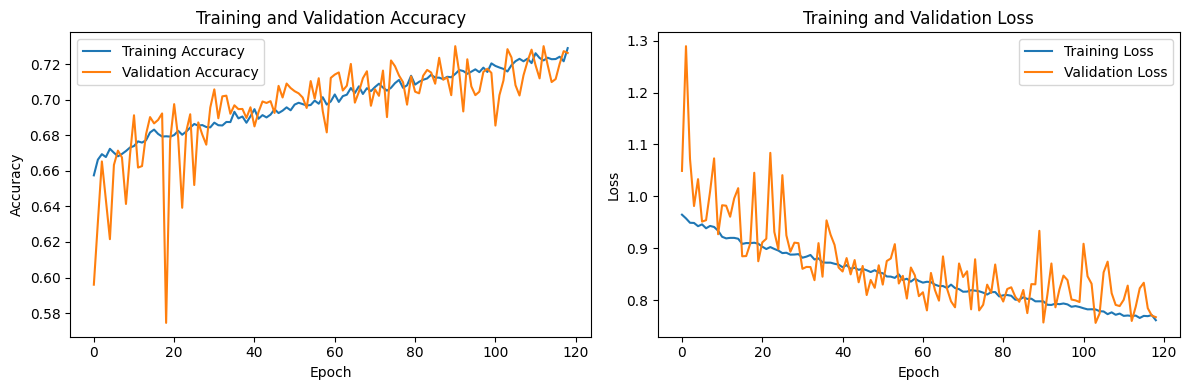

In [50]:
import matplotlib.pyplot as plt


accuracy = historyEnsembleNew.history['accuracy']
loss = historyEnsembleNew.history['loss']
val_accuracy = historyEnsembleNew.history['val_accuracy']
val_loss = historyEnsembleNew.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Ensamble 2 modelos con pesos ponderados.

- Model 2 CNN Paper: 71.03%, 
- Model 3 CNN propuesto Keras tuner 64 batch: 71.32% 

Se le entrega una importancia(ponderación) del 30% al modelo CNN Paper y 70% al modelo propuesto Keras tuner


In [104]:
#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')

In [105]:
# Clase para calcular la combinación ponderada de dos modelos
class WeightedAverageLayer(tf.keras.layers.Layer): #Pesos ponderados
    def __init__(self, w1, w2, **kwargs): #Ingresa cada modelo
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] #Se multiplica el modelo por el valor ponderado ingresado

    def get_config(self):
        config = super(WeightedAverageLayer, self).get_config()
        config.update({
            'w1': self.w1,
            'w2': self.w2
        })
        return config


In [106]:
# Concadenar modelos
models3 = [model_2, model_3] 

model_input3 = Input(shape=(48,48,3)) #se define la entrada
model_outputs3 = [model(model_input3) for model in models3] #se ingresa la entrada a cada modelo
dropout_outputs3 = [Dropout(0.3)(output) for output in model_outputs3]

#Se define que se desarrolle el ensamble mediante el promedio ponderado de los 2 modelos. Dandole una importancia del 30% al modelo CNN y 70% al modelo propuesto
ensemble_output3 = WeightedAverageLayer(0.3 , 0.7)(dropout_outputs3)

#Se define el modelo final
ensemble_model3 = Model(inputs = model_input3, outputs=ensemble_output3, name="ensemble_model")

ensemble_model3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ensemble_model3.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_25[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_25[0][0]']               
                                                                                                  
 dropout_33 (Dropout)           (None, 7)            0           ['model_2[0][0]']                
                                                                                     

In [107]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/2ModelsPesosPonderados/64batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/2ModelsPesosPonderados/64batch/best_model_2ModelsPesosPonderados_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='max',               # Modo 'max' significa guardar el modelo cuando la métrica monitor alcanza su máximo
    verbose=1                 # Muestra información detallada
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/2ModelsPesosPonderados/64batch', exist_ok=True)



log_dir = "logs/ModelEnsamble/2ModelsPesosPonderados/64batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [108]:
historyEnsemble2ModelsPonderado = ensemble_model3.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]

)

Epoch 1/300
670/670 [==============================] - ETA: 0s - loss: 2.5080 - accuracy: 0.5157
Epoch 1: val_accuracy improved from -inf to 0.48702, saving model to models/ModelEnsamble/2ModelsPesosPonderados/64batch\best_model_2ModelsPesosPonderados_1_0.4870.h5
670/670 [==============================] - 113s 165ms/step - loss: 2.5080 - accuracy: 0.5157 - val_loss: 1.2104 - val_accuracy: 0.4870
Epoch 2/300
670/670 [==============================] - ETA: 0s - loss: 2.4997 - accuracy: 0.5190
Epoch 2: val_accuracy improved from 0.48702 to 0.63567, saving model to models/ModelEnsamble/2ModelsPesosPonderados/64batch\best_model_2ModelsPesosPonderados_2_0.6357.h5
670/670 [==============================] - 110s 164ms/step - loss: 2.4997 - accuracy: 0.5190 - val_loss: 1.1876 - val_accuracy: 0.6357
Epoch 3/300
670/670 [==============================] - ETA: 0s - loss: 2.5134 - accuracy: 0.5233
Epoch 3: val_accuracy did not improve from 0.63567
670/670 [==============================] - 110s 165

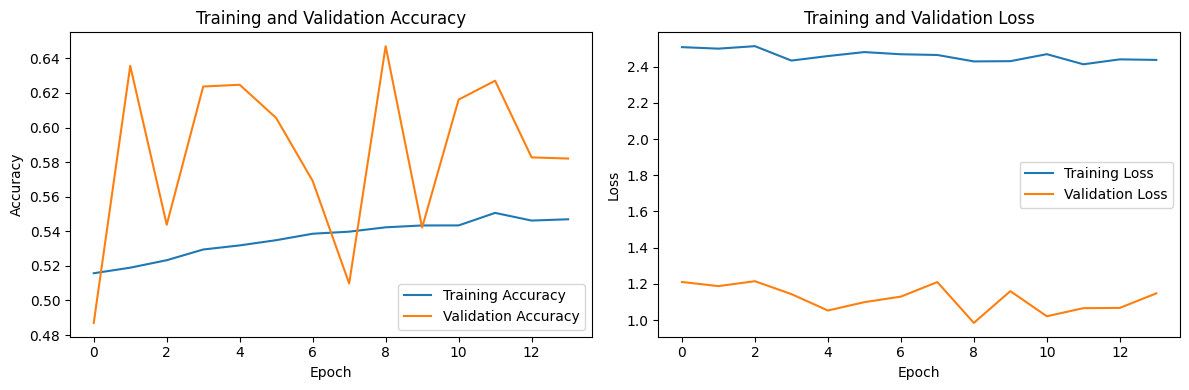

In [109]:
import matplotlib.pyplot as plt


accuracy = historyEnsemble2ModelsPonderado.history['accuracy']
loss = historyEnsemble2ModelsPonderado.history['loss']
val_accuracy = historyEnsemble2ModelsPonderado.history['val_accuracy']
val_loss = historyEnsemble2ModelsPonderado.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Con batch_size de 100

In [117]:
#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/Model 3 Keras tunner/modelKerasTuner/64batch/best_model_modelKerasTuner_114_0.7132.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')

In [118]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

    def get_config(self):
        config = super(WeightedAverageLayer, self).get_config()
        config.update({
            'w1': self.w1,
            'w2': self.w2
        })
        return config


In [119]:
# Concadenar modelos

models3 = [model_2, model_3] #se concadena todo en uno

model_input3 = Input(shape=(48,48,3)) #se define la entrada
model_outputs3 = [model(model_input3) for model in models3] #se ingresa la entrada a cada modelo
dropout_outputs3 = [Dropout(0.3)(output) for output in model_outputs3]

#Se define que se desarrolle el ensamble mediante el promedio ponderado de los 2 modelos. Dandole una importancia del 30% al modelo CNN y 70% al modelo propuesto
ensemble_output3 = WeightedAverageLayer(0.3 , 0.7)(dropout_outputs3)

#Se define el modelo final
ensemble_model3 = Model(inputs = model_input3, outputs=ensemble_output3, name="ensemble_model")

ensemble_model3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ensemble_model3.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_27[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_27[0][0]']               
                                                                                                  
 dropout_38 (Dropout)           (None, 7)            0           ['model_2[0][0]']                
                                                                                     

In [120]:
#--------Early stopping---------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



#--------------------Checkpoint--------------------

os.makedirs('models/ModelEnsamble/2ModelsPesosPonderados/100batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/2ModelsPesosPonderados/100batch/best_model_2ModelsPesosPonderados_{epoch}_{val_accuracy:.4f}.h5'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Métrica a monitorear
    save_best_only=True,      # Guardar solo el mejor modelo
    mode='max',               # Modo 'max' significa guardar el modelo cuando la métrica monitor alcanza su máximo
    verbose=1                 # Muestra información detallada
)

#----------------Tensorboard-------------------
%load_ext tensorboard


os.makedirs('logs/ModelEnsamble/2ModelsPesosPonderados/100batch', exist_ok=True)



log_dir = "logs/ModelEnsamble/2ModelsPesosPonderados/100batch/" + datetime.now().strftime("%Y%m%d-%H%M%S")


tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [121]:
historyEnsemble2ModelsPonderado = ensemble_model3.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]

)

Epoch 1/300
429/429 [==============================] - ETA: 0s - loss: 2.7461 - accuracy: 0.4178
Epoch 1: val_accuracy improved from -inf to 0.45070, saving model to models/ModelEnsamble/2ModelsPesosPonderados/100batch\best_model_2ModelsPesosPonderados_1_0.4507.h5
429/429 [==============================] - 112s 254ms/step - loss: 2.7461 - accuracy: 0.4178 - val_loss: 1.2544 - val_accuracy: 0.4507
Epoch 2/300
429/429 [==============================] - ETA: 0s - loss: 2.7037 - accuracy: 0.4275
Epoch 2: val_accuracy improved from 0.45070 to 0.52176, saving model to models/ModelEnsamble/2ModelsPesosPonderados/100batch\best_model_2ModelsPesosPonderados_2_0.5218.h5
429/429 [==============================] - 108s 250ms/step - loss: 2.7037 - accuracy: 0.4275 - val_loss: 1.2720 - val_accuracy: 0.5218
Epoch 3/300
429/429 [==============================] - ETA: 0s - loss: 2.6943 - accuracy: 0.4377
Epoch 3: val_accuracy improved from 0.52176 to 0.57320, saving model to models/ModelEnsamble/2Models

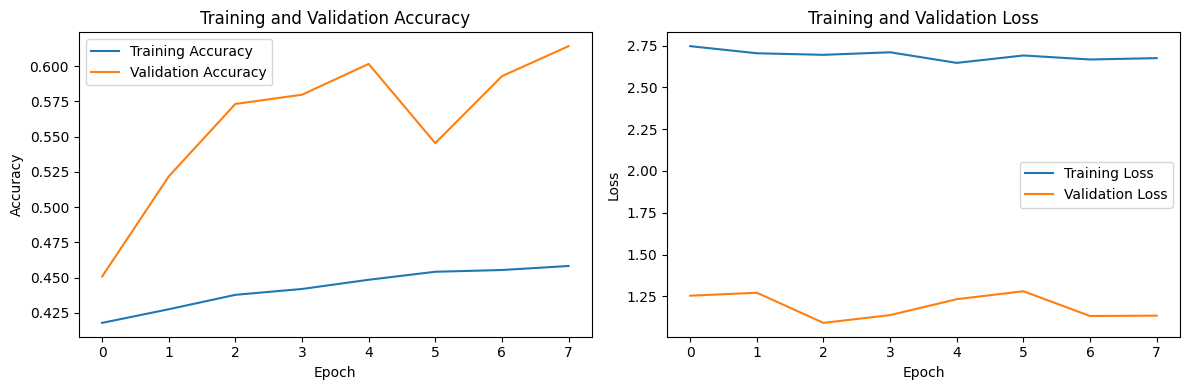

In [122]:
import matplotlib.pyplot as plt


accuracy = historyEnsemble2ModelsPonderado.history['accuracy']
loss = historyEnsemble2ModelsPonderado.history['loss']
val_accuracy = historyEnsemble2ModelsPonderado.history['val_accuracy']
val_loss = historyEnsemble2ModelsPonderado.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Ensamble 2 modelos con pesos ponderados.

- Model 2 CNN Paper: 71.03%, 
- Model 3 CNN propuesto Keras tuner 128 batch: 75.48% 

Se le entrega una importancia(ponderación) del 30% al modelo CNN Paper y 70% al modelo propuesto Keras tuner

In [51]:
#Model 2 71.03%
model_2 = load_model('models/Model 2 paper 2/paper 2 modelo bueno 64batch 48x48/best_model_ModelPaper2_133_0.7103.h5')

model_2 = Model(inputs = model_2.inputs, outputs=model_2.output, name='model_2')


#Model 3 71.32%
model_3 = load_model('models/modelKerasTuner/128batch/best_model_modelKerasTuner_186_0.7548.h5')

model_3 = Model(inputs = model_3.inputs, outputs=model_3.output, name='model_3')

In [3]:
# Clase para calcular la combinación ponderada de dos modelos
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1]

    def get_config(self):
        config = super(WeightedAverageLayer, self).get_config()
        config.update({
            'w1': self.w1,
            'w2': self.w2
        })
        return config

In [56]:
ModelPonderadoNew = [model_2, model_3]


input = Input(shape=(48,48,3))


model_output = [model(input) for model in ModelPonderadoNew]

model_output = WeightedAverageLayer(0.3, 0.7)(model_output) #Se entrega las ponderaciones de ambos modelos

ModelPonderadoNew = Model(inputs=input, outputs=model_output)

ModelPonderadoNew.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

ModelPonderadoNew.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 7)            1204935     ['input_11[0][0]']               
                                                                                                  
 model_3 (Functional)           (None, 7)            5924615     ['input_11[0][0]']               
                                                                                                  
 weighted_average_layer_1 (Weig  (None, 7)           0           ['model_2[1][0]',                
 htedAverageLayer)                                                'model_3[1][0]']         

In [57]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


os.makedirs('models/ModelEnsamble/EnsmbleNewPonderado/128batch', exist_ok=True)


checkpoint_path = 'models/ModelEnsamble/EnsmbleNewPonderado/128batch/'

# Callback de ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy', 
    save_best_only=True,      
    mode='max',               
    verbose=1                 
)

In [58]:
historyEnsembleNewPonderado = ModelPonderadoNew.fit(
    train_generator,
    epochs=300,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]

)

Epoch 1/300
335/335 [==============================] - ETA: 0s - loss: 0.9854 - accuracy: 0.6149
Epoch 1: val_accuracy improved from -inf to 0.60430, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 129s 379ms/step - loss: 0.9854 - accuracy: 0.6149 - val_loss: 1.0293 - val_accuracy: 0.6043
Epoch 2/300
335/335 [==============================] - ETA: 0s - loss: 1.0073 - accuracy: 0.6116
Epoch 2: val_accuracy did not improve from 0.60430
335/335 [==============================] - 114s 341ms/step - loss: 1.0073 - accuracy: 0.6116 - val_loss: 1.4365 - val_accuracy: 0.4031
Epoch 3/300
335/335 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.6121
Epoch 3: val_accuracy improved from 0.60430 to 0.61335, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 123s 368ms/step - loss: 1.0111 - accuracy: 0.6121 - val_loss: 1.0596 - val_accuracy: 0.6134
Epoch 4/300
335/335 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.6201
Epoch 4: val_accuracy did not improve from 0.61335
335/335 [==============================] - 111s 330ms/step - loss: 1.0049 - accuracy: 0.6201 - val_loss: 1.1340 - val_accuracy: 0.5831
Epoch 5/300
335/335 [==============================] - ETA: 0s - loss: 0.9976 - accuracy: 0.6247
Epoch 5: val_accuracy did not improve from 0.61335
335/335 [==============================] - 106s 315ms/step - loss: 0.9976 - accuracy: 0.6247 - val_loss: 1.1979 - val_accuracy: 0.4817
Epoch 6/300
335/335 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.6252
Epoch 6: val_accuracy did not improve from 0.61335
335/335 [==============================] - 102s 306ms/step - loss: 0.9928 - accuracy: 0.6252 - val_loss: 1.1184 - val_accuracy: 0.5626
Epoch 7/300
335/

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 110s 329ms/step - loss: 0.9866 - accuracy: 0.6320 - val_loss: 1.0055 - val_accuracy: 0.6416
Epoch 10/300
335/335 [==============================] - ETA: 0s - loss: 0.9789 - accuracy: 0.6345
Epoch 10: val_accuracy did not improve from 0.64164
335/335 [==============================] - 104s 310ms/step - loss: 0.9789 - accuracy: 0.6345 - val_loss: 1.2764 - val_accuracy: 0.4797
Epoch 11/300
335/335 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.6375
Epoch 11: val_accuracy improved from 0.64164 to 0.65602, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 112s 334ms/step - loss: 0.9725 - accuracy: 0.6375 - val_loss: 0.9419 - val_accuracy: 0.6560
Epoch 12/300
335/335 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.6325
Epoch 12: val_accuracy did not improve from 0.65602
335/335 [==============================] - 107s 318ms/step - loss: 0.9718 - accuracy: 0.6325 - val_loss: 1.0130 - val_accuracy: 0.6297
Epoch 13/300
335/335 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.6393
Epoch 13: val_accuracy did not improve from 0.65602
335/335 [==============================] - 106s 316ms/step - loss: 0.9682 - accuracy: 0.6393 - val_loss: 1.0124 - val_accuracy: 0.6278
Epoch 14/300
335/335 [==============================] - ETA: 0s - loss: 0.9624 - accuracy: 0.6403
Epoch 14: val_accuracy improved from 0.65602 to 0.65630, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 112s 333ms/step - loss: 0.9624 - accuracy: 0.6403 - val_loss: 0.9425 - val_accuracy: 0.6563
Epoch 15/300
335/335 [==============================] - ETA: 0s - loss: 0.9557 - accuracy: 0.6450
Epoch 15: val_accuracy improved from 0.65630 to 0.66517, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 112s 334ms/step - loss: 0.9557 - accuracy: 0.6450 - val_loss: 0.9331 - val_accuracy: 0.6652
Epoch 16/300
335/335 [==============================] - ETA: 0s - loss: 0.9535 - accuracy: 0.6465
Epoch 16: val_accuracy did not improve from 0.66517
335/335 [==============================] - 105s 314ms/step - loss: 0.9535 - accuracy: 0.6465 - val_loss: 0.9249 - val_accuracy: 0.6477
Epoch 17/300
335/335 [==============================] - ETA: 0s - loss: 0.9588 - accuracy: 0.6438
Epoch 17: val_accuracy did not improve from 0.66517
335/335 [==============================] - 106s 316ms/step - loss: 0.9588 - accuracy: 0.6438 - val_loss: 1.1795 - val_accuracy: 0.5443
Epoch 18/300
335/335 [==============================] - ETA: 0s - loss: 0.9535 - accuracy: 0.6434
Epoch 18: val_accuracy did not improve from 0.66517
335/335 [==============================] - 105s 314ms/step - loss: 0.9535 - accuracy: 0.6434 - val_loss: 0.9104 - val_accuracy: 0.6528
Epoch 19/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 120s 359ms/step - loss: 0.9152 - accuracy: 0.6573 - val_loss: 0.8836 - val_accuracy: 0.6741
Epoch 29/300
335/335 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.6570
Epoch 29: val_accuracy did not improve from 0.67414
335/335 [==============================] - 117s 348ms/step - loss: 0.9172 - accuracy: 0.6570 - val_loss: 0.8566 - val_accuracy: 0.6723
Epoch 30/300
335/335 [==============================] - ETA: 0s - loss: 0.9124 - accuracy: 0.6595
Epoch 30: val_accuracy did not improve from 0.67414
335/335 [==============================] - 119s 355ms/step - loss: 0.9124 - accuracy: 0.6595 - val_loss: 1.1968 - val_accuracy: 0.5456
Epoch 31/300
335/335 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.6573
Epoch 31: val_accuracy did not improve from 0.67414
335/335 [==============================] - 118s 353ms/step - loss: 0.9178 - accuracy: 0.6573 - val_loss: 0.9592 - val_accuracy: 0.6428
Epoch 32/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 121s 361ms/step - loss: 0.8937 - accuracy: 0.6669 - val_loss: 0.8872 - val_accuracy: 0.6760
Epoch 36/300
335/335 [==============================] - ETA: 0s - loss: 0.8954 - accuracy: 0.6636
Epoch 36: val_accuracy did not improve from 0.67600
335/335 [==============================] - 109s 325ms/step - loss: 0.8954 - accuracy: 0.6636 - val_loss: 1.0270 - val_accuracy: 0.6096
Epoch 37/300
335/335 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.6698
Epoch 37: val_accuracy improved from 0.67600 to 0.67712, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 115s 344ms/step - loss: 0.8908 - accuracy: 0.6698 - val_loss: 0.8703 - val_accuracy: 0.6771
Epoch 38/300
335/335 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.6645
Epoch 38: val_accuracy did not improve from 0.67712
335/335 [==============================] - 106s 317ms/step - loss: 0.8927 - accuracy: 0.6645 - val_loss: 0.9445 - val_accuracy: 0.6499
Epoch 39/300
335/335 [==============================] - ETA: 0s - loss: 0.8856 - accuracy: 0.6664
Epoch 39: val_accuracy improved from 0.67712 to 0.68385, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 113s 336ms/step - loss: 0.8856 - accuracy: 0.6664 - val_loss: 0.8591 - val_accuracy: 0.6838
Epoch 40/300
335/335 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.6699
Epoch 40: val_accuracy did not improve from 0.68385
335/335 [==============================] - 105s 311ms/step - loss: 0.8852 - accuracy: 0.6699 - val_loss: 1.0165 - val_accuracy: 0.6194
Epoch 41/300
335/335 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.6740
Epoch 41: val_accuracy improved from 0.68385 to 0.69010, saving model to models/ModelEnsamble/EnsmbleNewPonderado/128batch\


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 113s 338ms/step - loss: 0.8798 - accuracy: 0.6740 - val_loss: 0.8290 - val_accuracy: 0.6901
Epoch 42/300
335/335 [==============================] - ETA: 0s - loss: 0.8822 - accuracy: 0.6678
Epoch 42: val_accuracy did not improve from 0.69010
335/335 [==============================] - 105s 312ms/step - loss: 0.8822 - accuracy: 0.6678 - val_loss: 0.8905 - val_accuracy: 0.6655
Epoch 43/300
335/335 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.6706
Epoch 43: val_accuracy did not improve from 0.69010
335/335 [==============================] - 105s 313ms/step - loss: 0.8800 - accuracy: 0.6706 - val_loss: 0.9999 - val_accuracy: 0.6158
Epoch 44/300
335/335 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.6729
Epoch 44: val_accuracy did not improve from 0.69010
335/335 [==============================] - 109s 325ms/step - loss: 0.8795 - accuracy: 0.6729 - val_loss: 0.8734 - val_accuracy: 0.6773
Epoch 45/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 111s 332ms/step - loss: 0.8524 - accuracy: 0.6809 - val_loss: 0.8066 - val_accuracy: 0.6966
Epoch 53/300
335/335 [==============================] - ETA: 0s - loss: 0.8567 - accuracy: 0.6798
Epoch 53: val_accuracy did not improve from 0.69664
335/335 [==============================] - 112s 334ms/step - loss: 0.8567 - accuracy: 0.6798 - val_loss: 0.8493 - val_accuracy: 0.6862
Epoch 54/300
335/335 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.6805
Epoch 54: val_accuracy did not improve from 0.69664
335/335 [==============================] - 108s 321ms/step - loss: 0.8500 - accuracy: 0.6805 - val_loss: 0.8425 - val_accuracy: 0.6870
Epoch 55/300
335/335 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.6855
Epoch 55: val_accuracy did not improve from 0.69664
335/335 [==============================] - 107s 320ms/step - loss: 0.8459 - accuracy: 0.6855 - val_loss: 0.9427 - val_accuracy: 0.6486
Epoch 56/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 112s 335ms/step - loss: 0.8309 - accuracy: 0.6895 - val_loss: 0.7887 - val_accuracy: 0.7102
Epoch 62/300
335/335 [==============================] - ETA: 0s - loss: 0.8333 - accuracy: 0.6887
Epoch 62: val_accuracy did not improve from 0.71018
335/335 [==============================] - 105s 311ms/step - loss: 0.8333 - accuracy: 0.6887 - val_loss: 0.8182 - val_accuracy: 0.6944
Epoch 63/300
335/335 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.6938
Epoch 63: val_accuracy did not improve from 0.71018
335/335 [==============================] - 103s 308ms/step - loss: 0.8224 - accuracy: 0.6938 - val_loss: 0.8572 - val_accuracy: 0.6826
Epoch 64/300
335/335 [==============================] - ETA: 0s - loss: 0.8281 - accuracy: 0.6888
Epoch 64: val_accuracy did not improve from 0.71018
335/335 [==============================] - 103s 307ms/step - loss: 0.8281 - accuracy: 0.6888 - val_loss: 0.9398 - val_accuracy: 0.6358
Epoch 65/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 112s 333ms/step - loss: 0.7921 - accuracy: 0.7046 - val_loss: 0.7451 - val_accuracy: 0.7179
Epoch 83/300
335/335 [==============================] - ETA: 0s - loss: 0.7940 - accuracy: 0.7042
Epoch 83: val_accuracy did not improve from 0.71793
335/335 [==============================] - 104s 310ms/step - loss: 0.7940 - accuracy: 0.7042 - val_loss: 0.8547 - val_accuracy: 0.6834
Epoch 84/300
335/335 [==============================] - ETA: 0s - loss: 0.7885 - accuracy: 0.7063
Epoch 84: val_accuracy did not improve from 0.71793
335/335 [==============================] - 142s 425ms/step - loss: 0.7885 - accuracy: 0.7063 - val_loss: 0.8004 - val_accuracy: 0.7018
Epoch 85/300
335/335 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.7079
Epoch 85: val_accuracy did not improve from 0.71793
335/335 [==============================] - 107s 320ms/step - loss: 0.7867 - accuracy: 0.7079 - val_loss: 0.8600 - val_accuracy: 0.6810
Epoch 86/3

INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


INFO:tensorflow:Assets written to: models/ModelEnsamble/EnsmbleNewPonderado/128batch\assets


335/335 [==============================] - 111s 333ms/step - loss: 0.7730 - accuracy: 0.7125 - val_loss: 0.7505 - val_accuracy: 0.7212
Epoch 94/300
335/335 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.7177
Epoch 94: val_accuracy did not improve from 0.72120
335/335 [==============================] - 104s 311ms/step - loss: 0.7671 - accuracy: 0.7177 - val_loss: 0.7989 - val_accuracy: 0.7088
Epoch 95/300
335/335 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.7158
Epoch 95: val_accuracy did not improve from 0.72120
335/335 [==============================] - 104s 312ms/step - loss: 0.7658 - accuracy: 0.7158 - val_loss: 0.8101 - val_accuracy: 0.7027
Epoch 96/300
335/335 [==============================] - ETA: 0s - loss: 0.7670 - accuracy: 0.7136
Epoch 96: val_accuracy did not improve from 0.72120
335/335 [==============================] - 104s 310ms/step - loss: 0.7670 - accuracy: 0.7136 - val_loss: 0.8330 - val_accuracy: 0.6950
Epoch 97/3

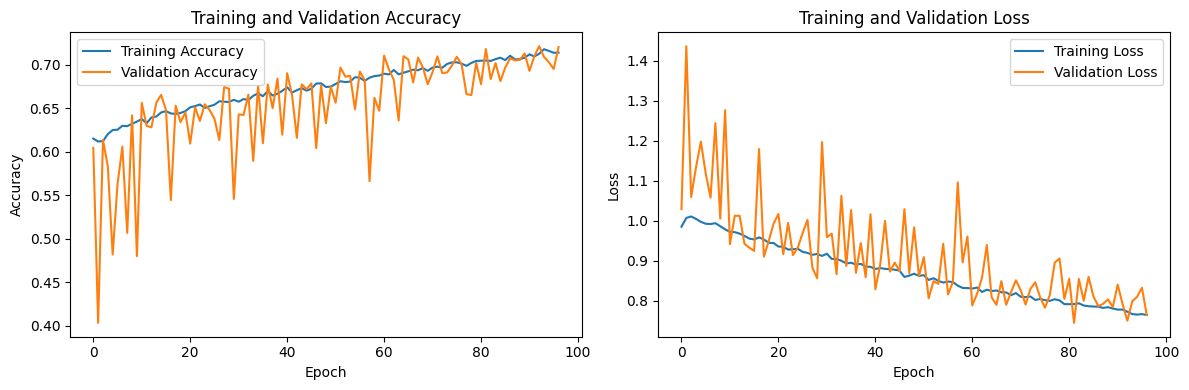

In [60]:
import matplotlib.pyplot as plt


accuracy = historyEnsembleNewPonderado.history['accuracy']
loss = historyEnsembleNewPonderado.history['loss']
val_accuracy = historyEnsembleNewPonderado.history['val_accuracy']
val_loss = historyEnsembleNewPonderado.history['val_loss']


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()